### Import Libraries


In [1]:
import pathlib
from joblib import load
import itertools

import pandas as pd
from matplotlib import pyplot as plt

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_F1_score, get_SCM_model_data

### Load Necessary Data


In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

### Evaluate Each Model on Each Dataset (multi class models)


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


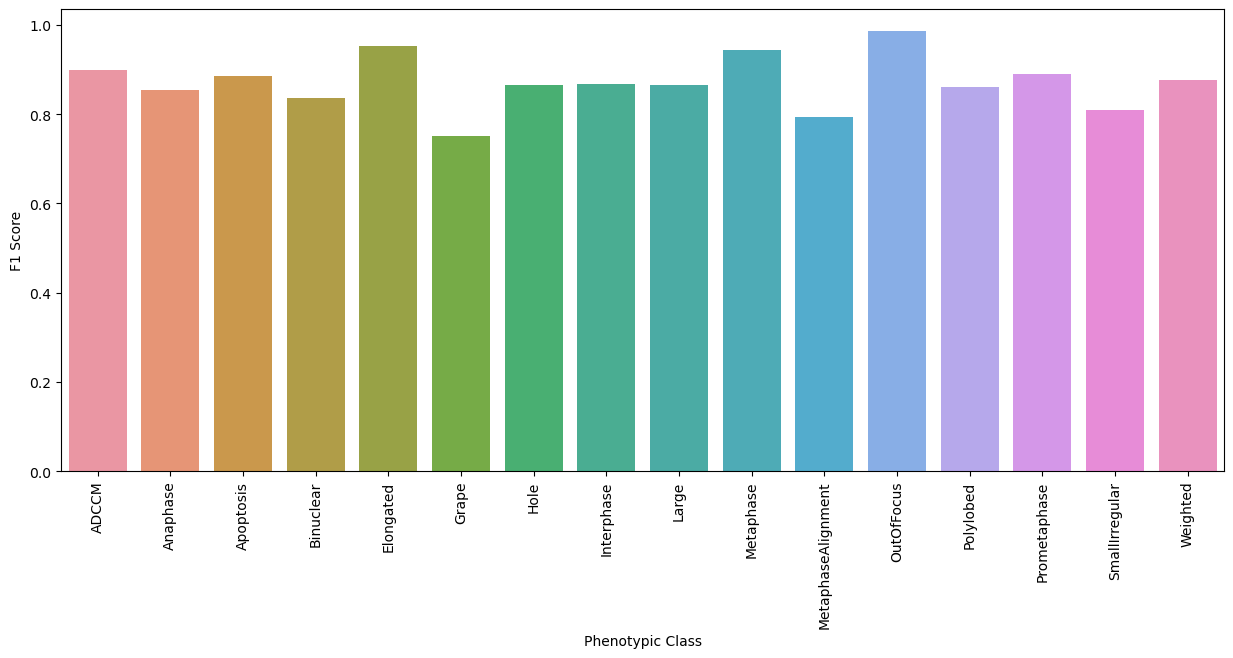

Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: test


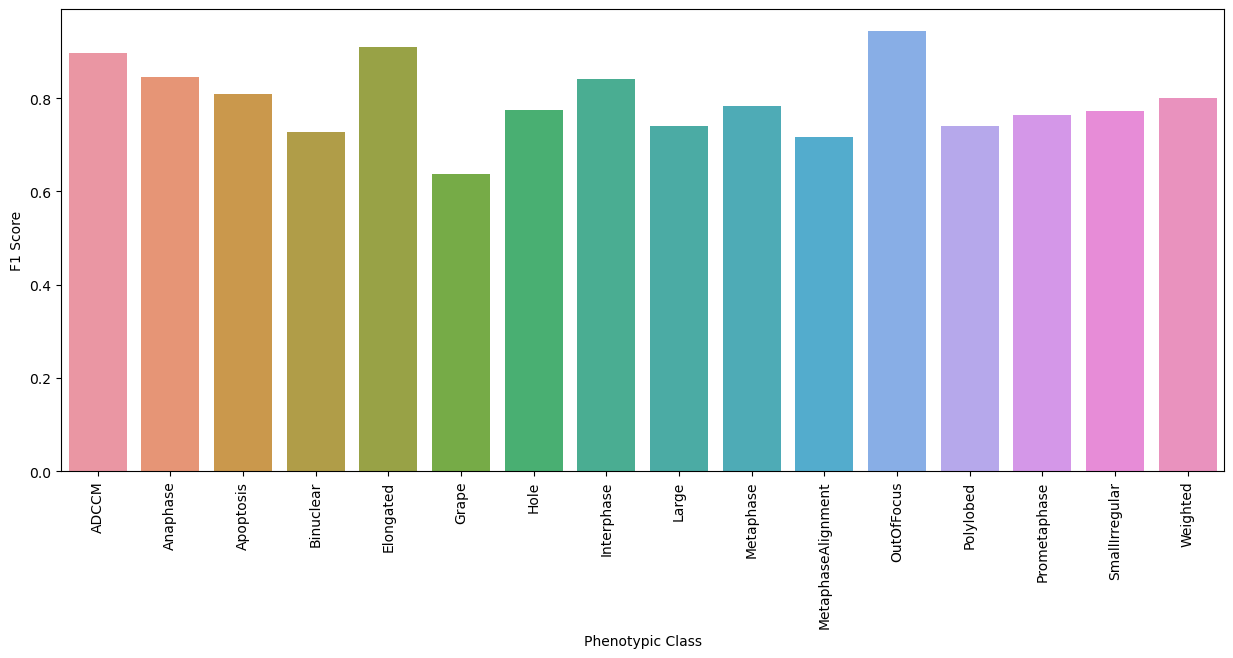

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: train


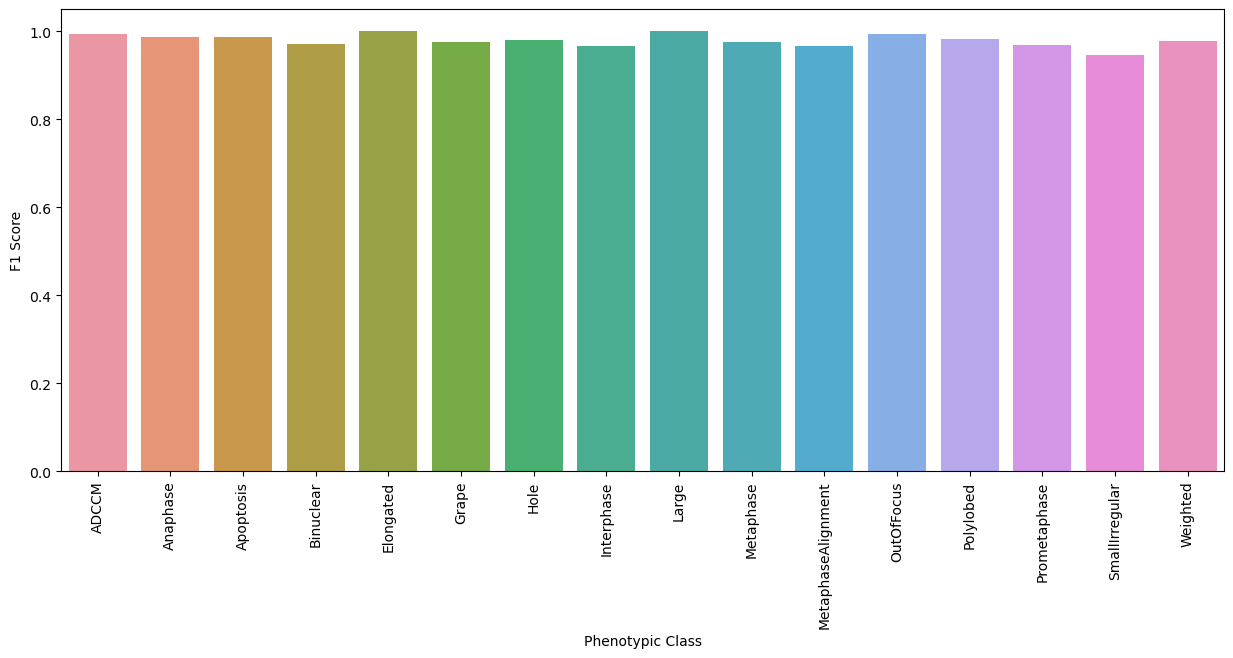

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: test


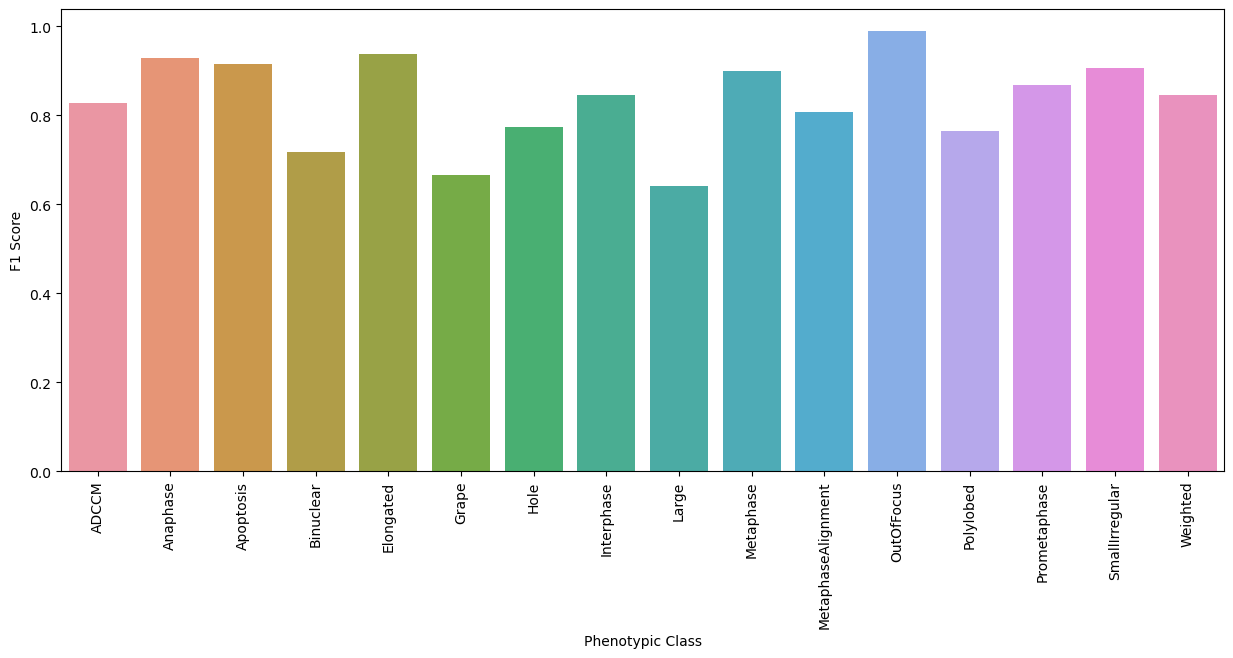

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: train


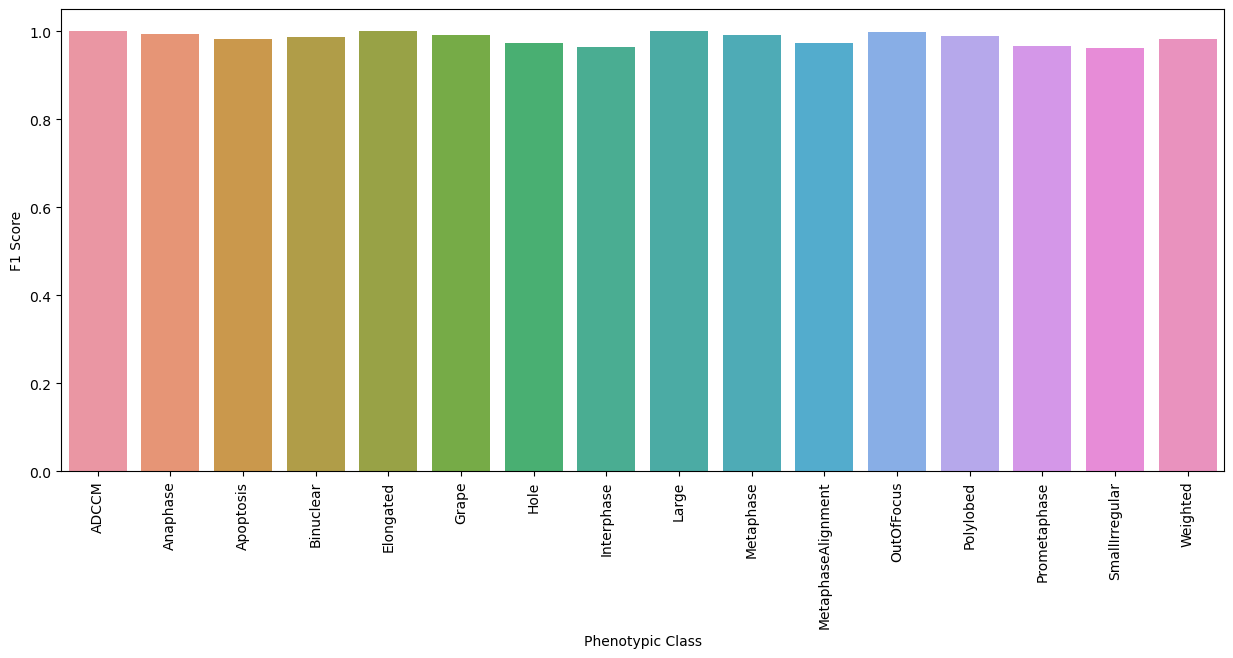

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: test


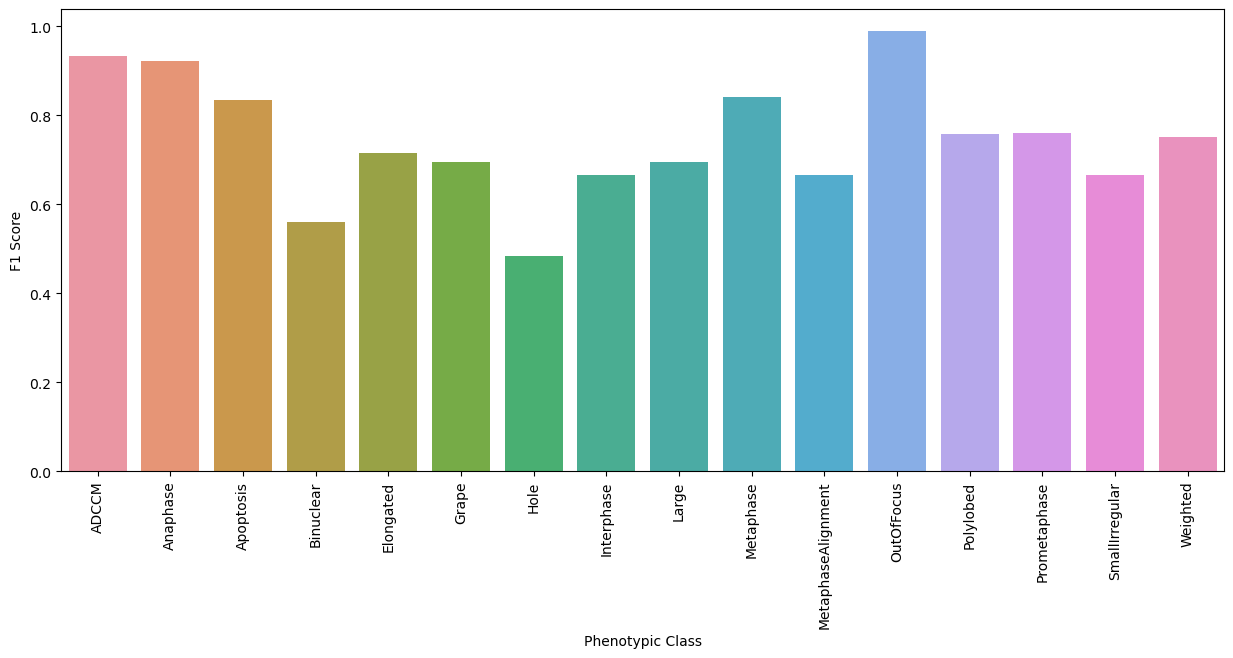

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: train


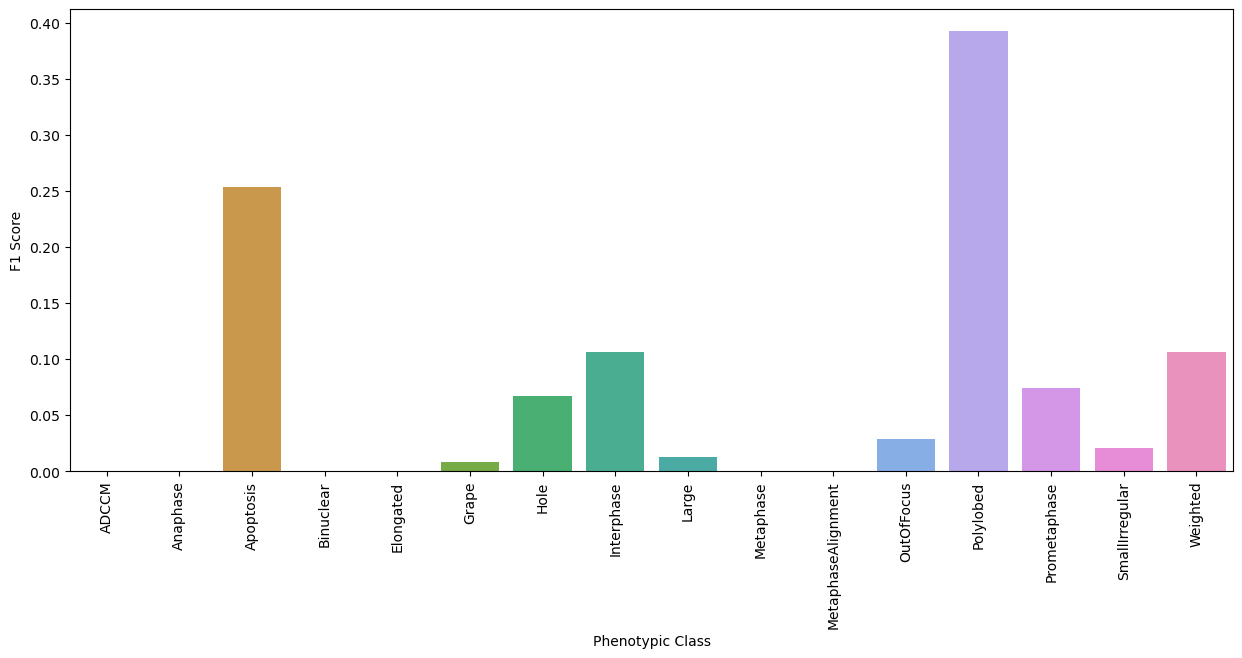

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: test


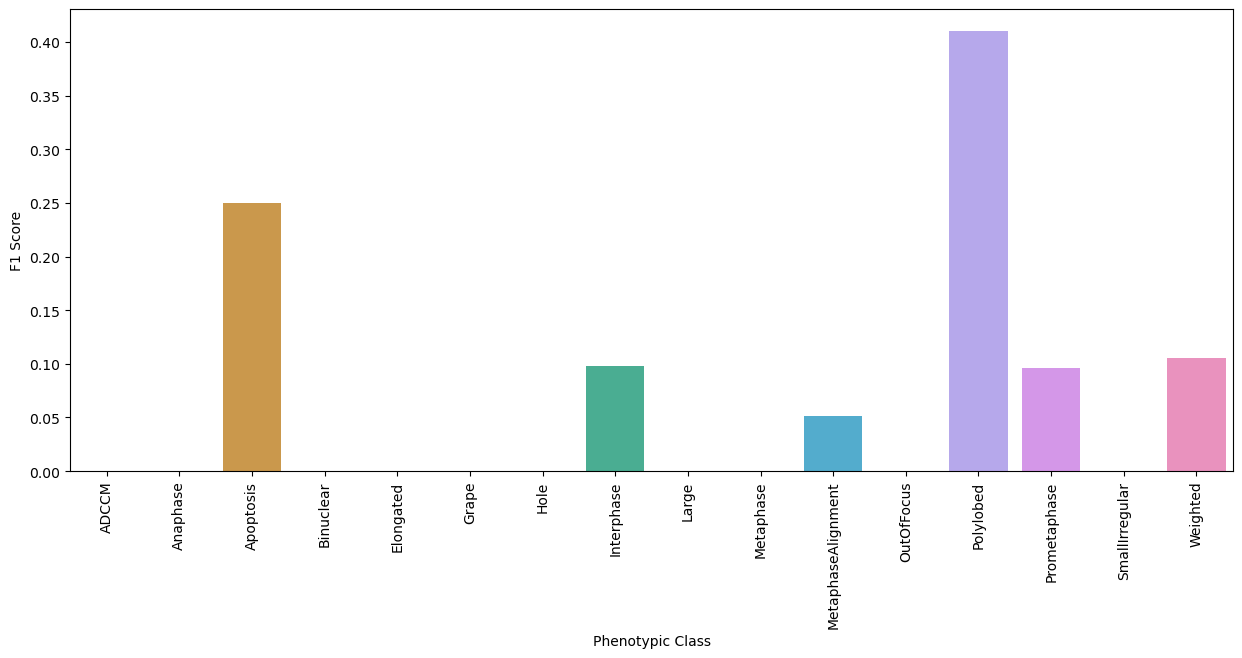

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: train


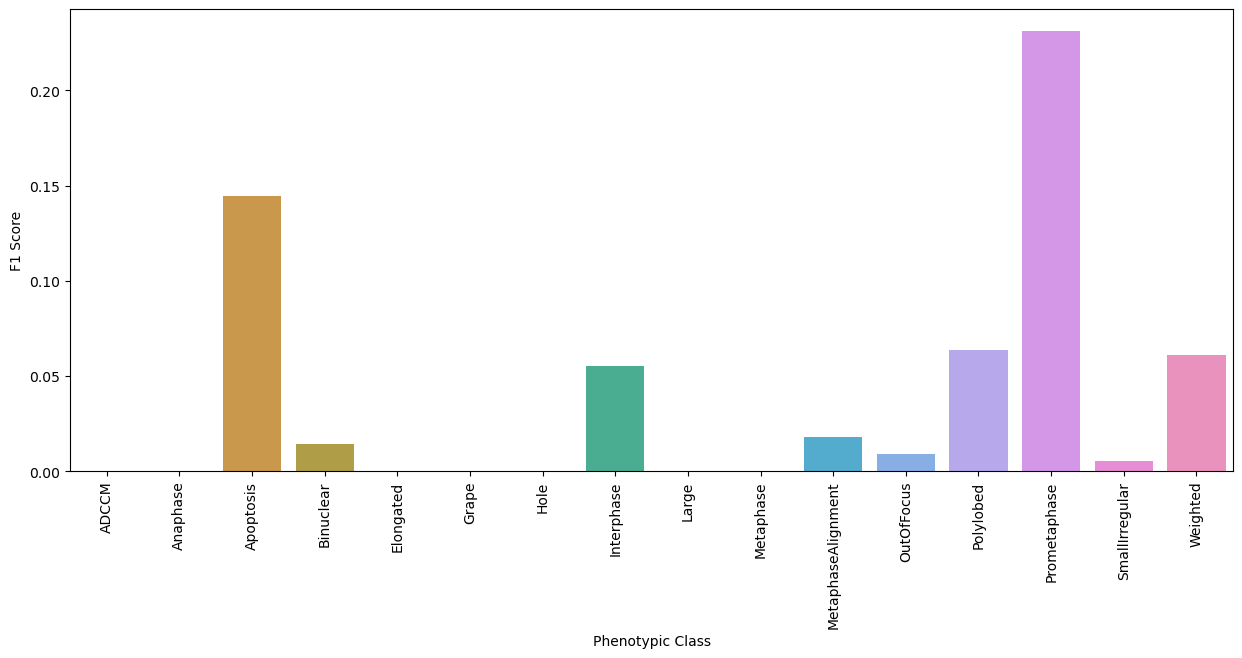

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: test


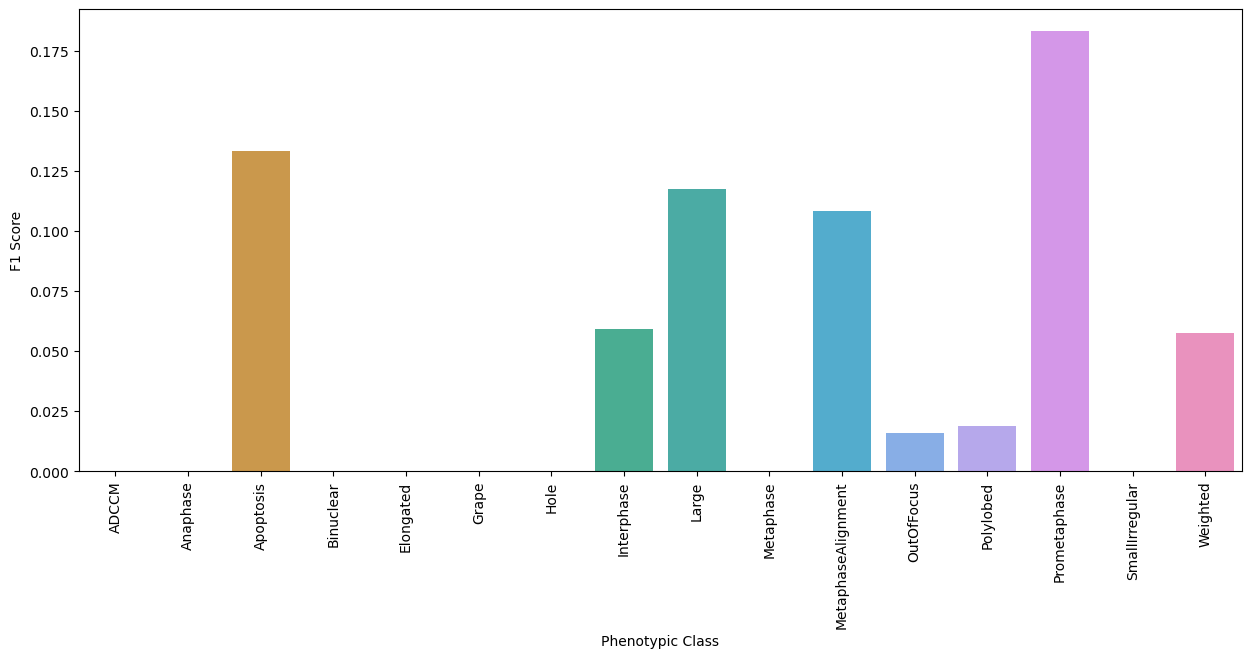

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: train


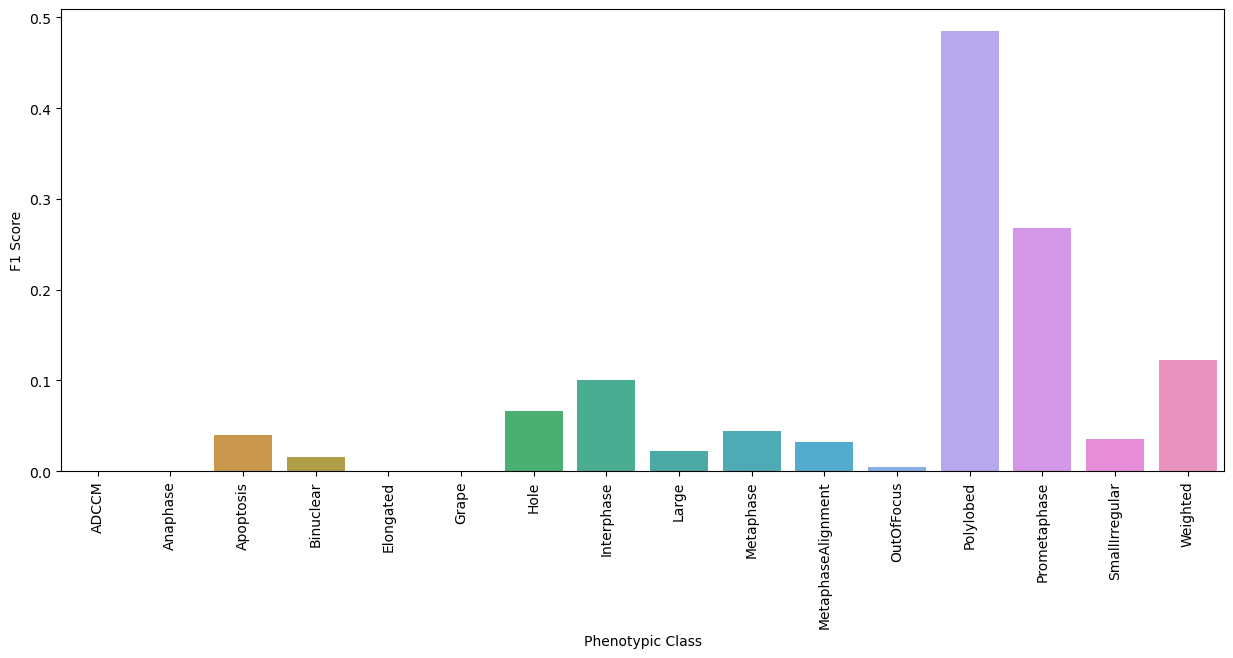

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: test


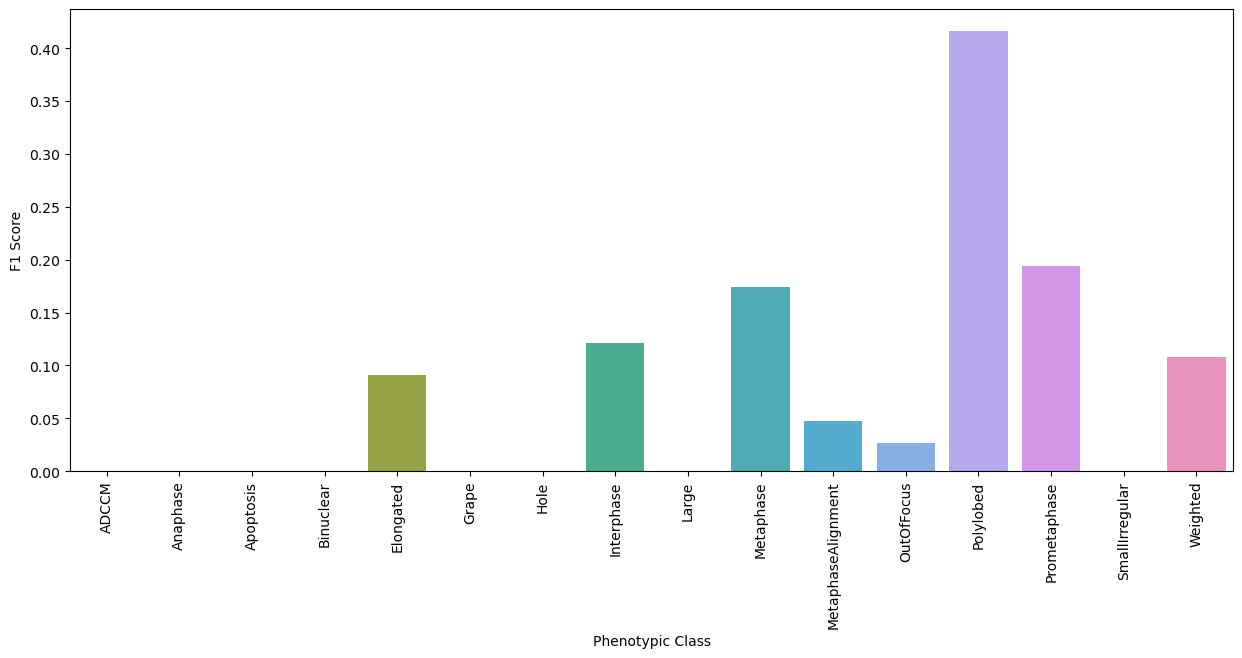

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_scores = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # find model F1 scores on dataset and create bar graph for them
        plt.figure(figsize=(15, 6))
        score, ax = model_F1_score(model, data, feature_type)
        ax.set_xlabel("Phenotypic Class")
        ax.set_ylabel("F1 Score")
        plt.show()

        # add score data to compiled dataframe in tidy format
        # transpose data and reset index to make dataframe resemble tidy long format
        score = score.T.reset_index()
        # change columns to their respective names
        score.columns = ["Phenotypic_Class", "F1_Score"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        score["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        score["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        score["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_scores.append(score)

### Save scores from each evaluation (multi class models)


In [4]:
# compile list of tidy data into one dataframe
compiled_scores = pd.concat(compiled_scores).reset_index(drop=True)

# specify results directory
f1_scores_dir = pathlib.Path("evaluations/F1_scores/")
f1_scores_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_scores_save_path = pathlib.Path(f"{f1_scores_dir}/compiled_F1_scores.tsv")

# save data as tsv
compiled_scores.to_csv(compiled_scores_save_path, sep="\t")

# preview tidy data
compiled_scores

,Phenotypic_Class,F1_Score,data_split,shuffled,feature_type
0,ADCCM,0.900000,train,False,CP
1,Anaphase,0.855172,train,False,CP
2,Apoptosis,0.886076,train,False,CP
3,Binuclear,0.837061,train,False,CP
4,Elongated,0.952880,train,False,CP
...,...,...,...,...,...
187,OutOfFocus,0.026316,test,True,DP
188,Polylobed,0.416185,test,True,DP
189,Prometaphase,0.193548,test,True,DP
190,SmallIrregular,0.000000,test,True,DP


### Evaluate Each Model on Each Dataset (single class models)


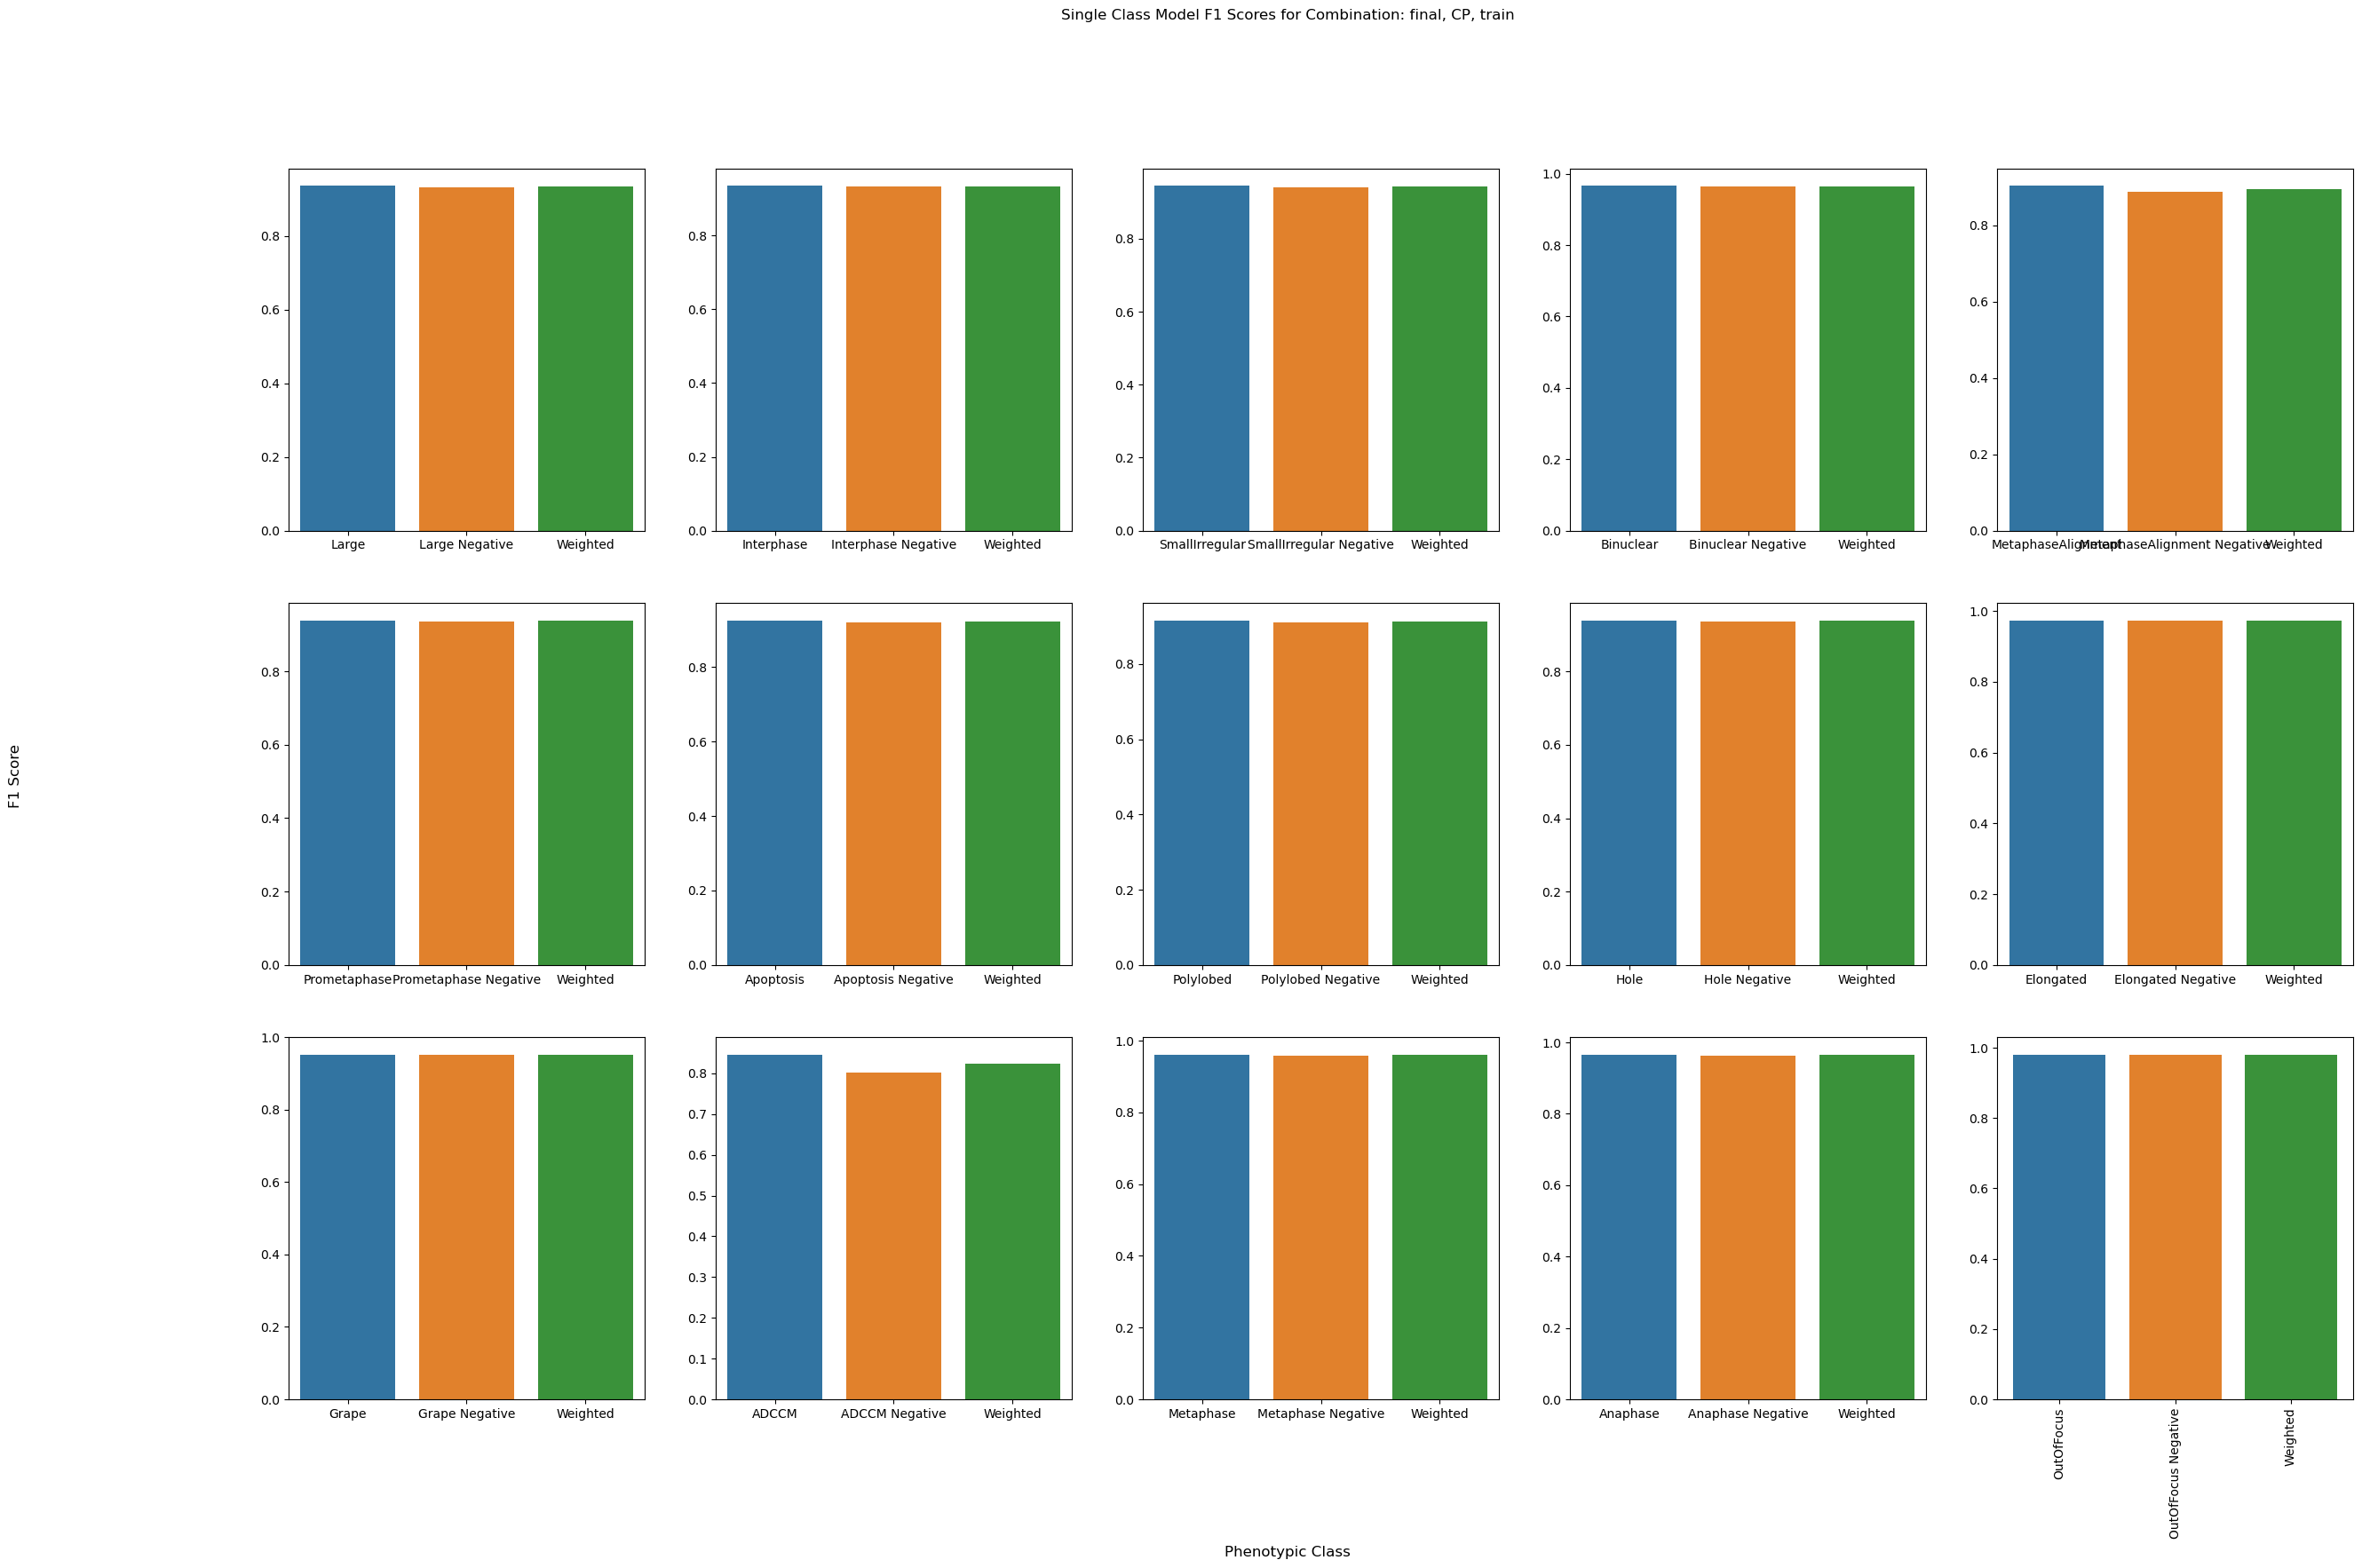

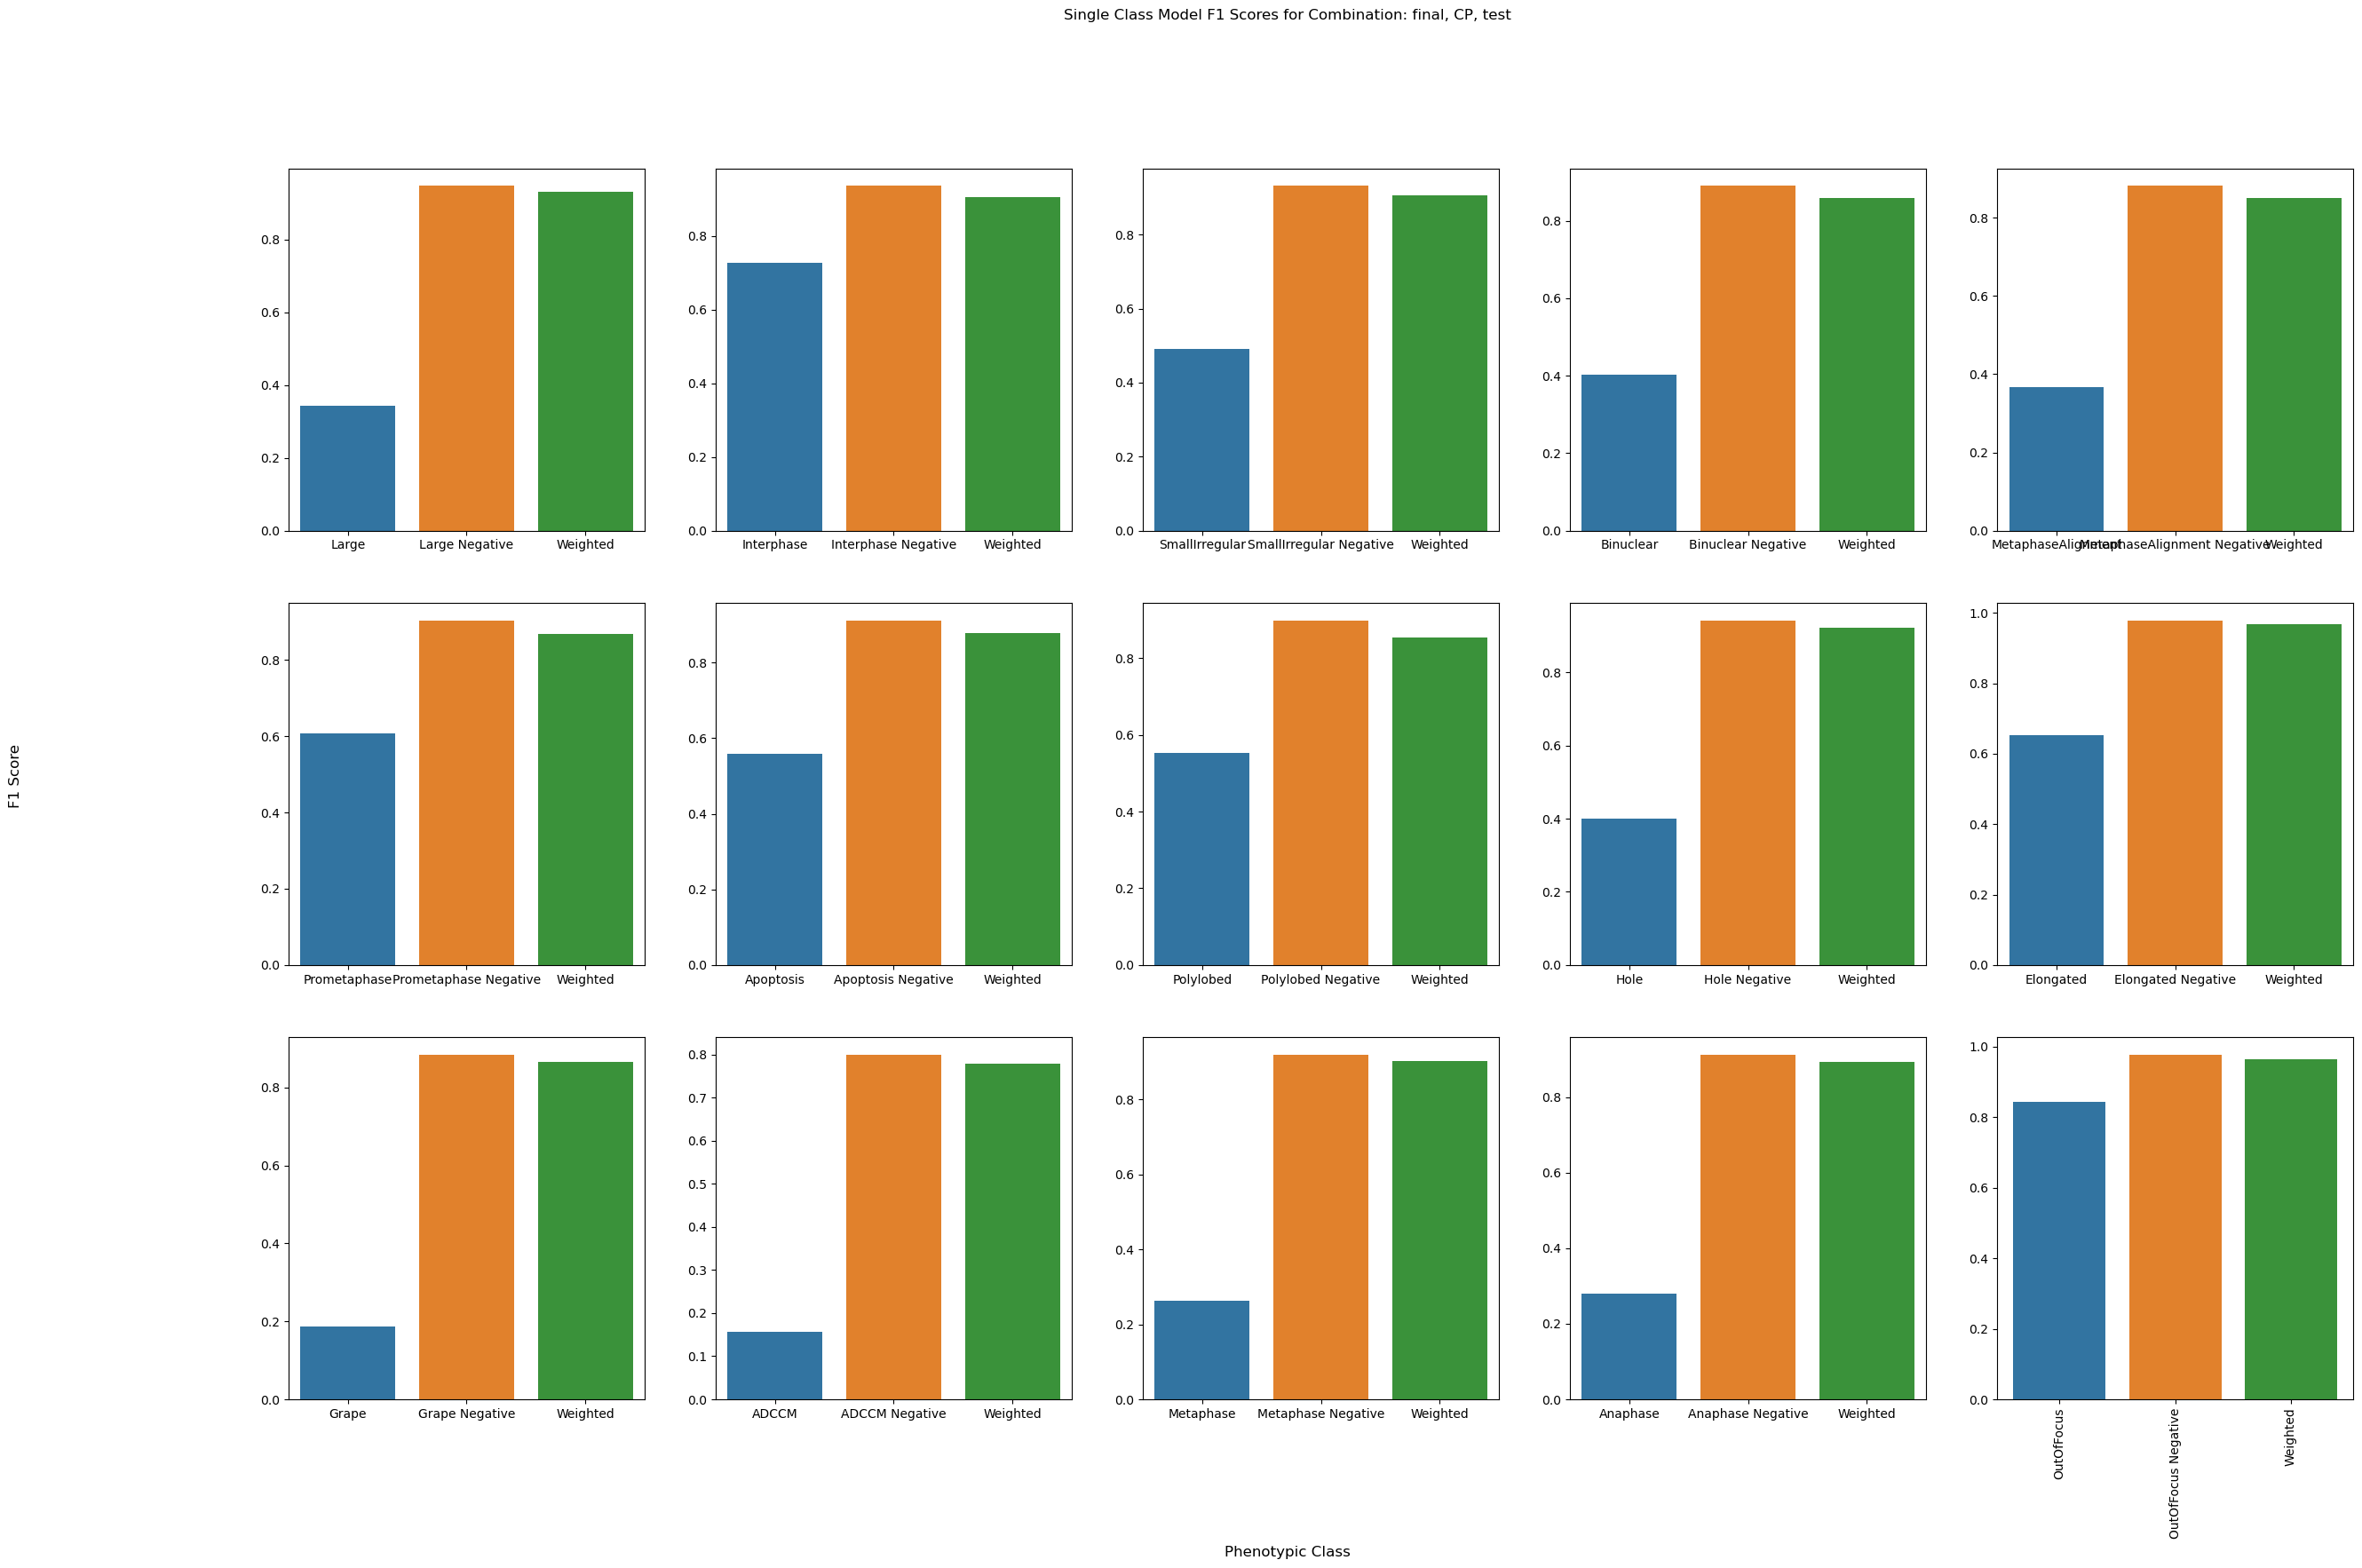

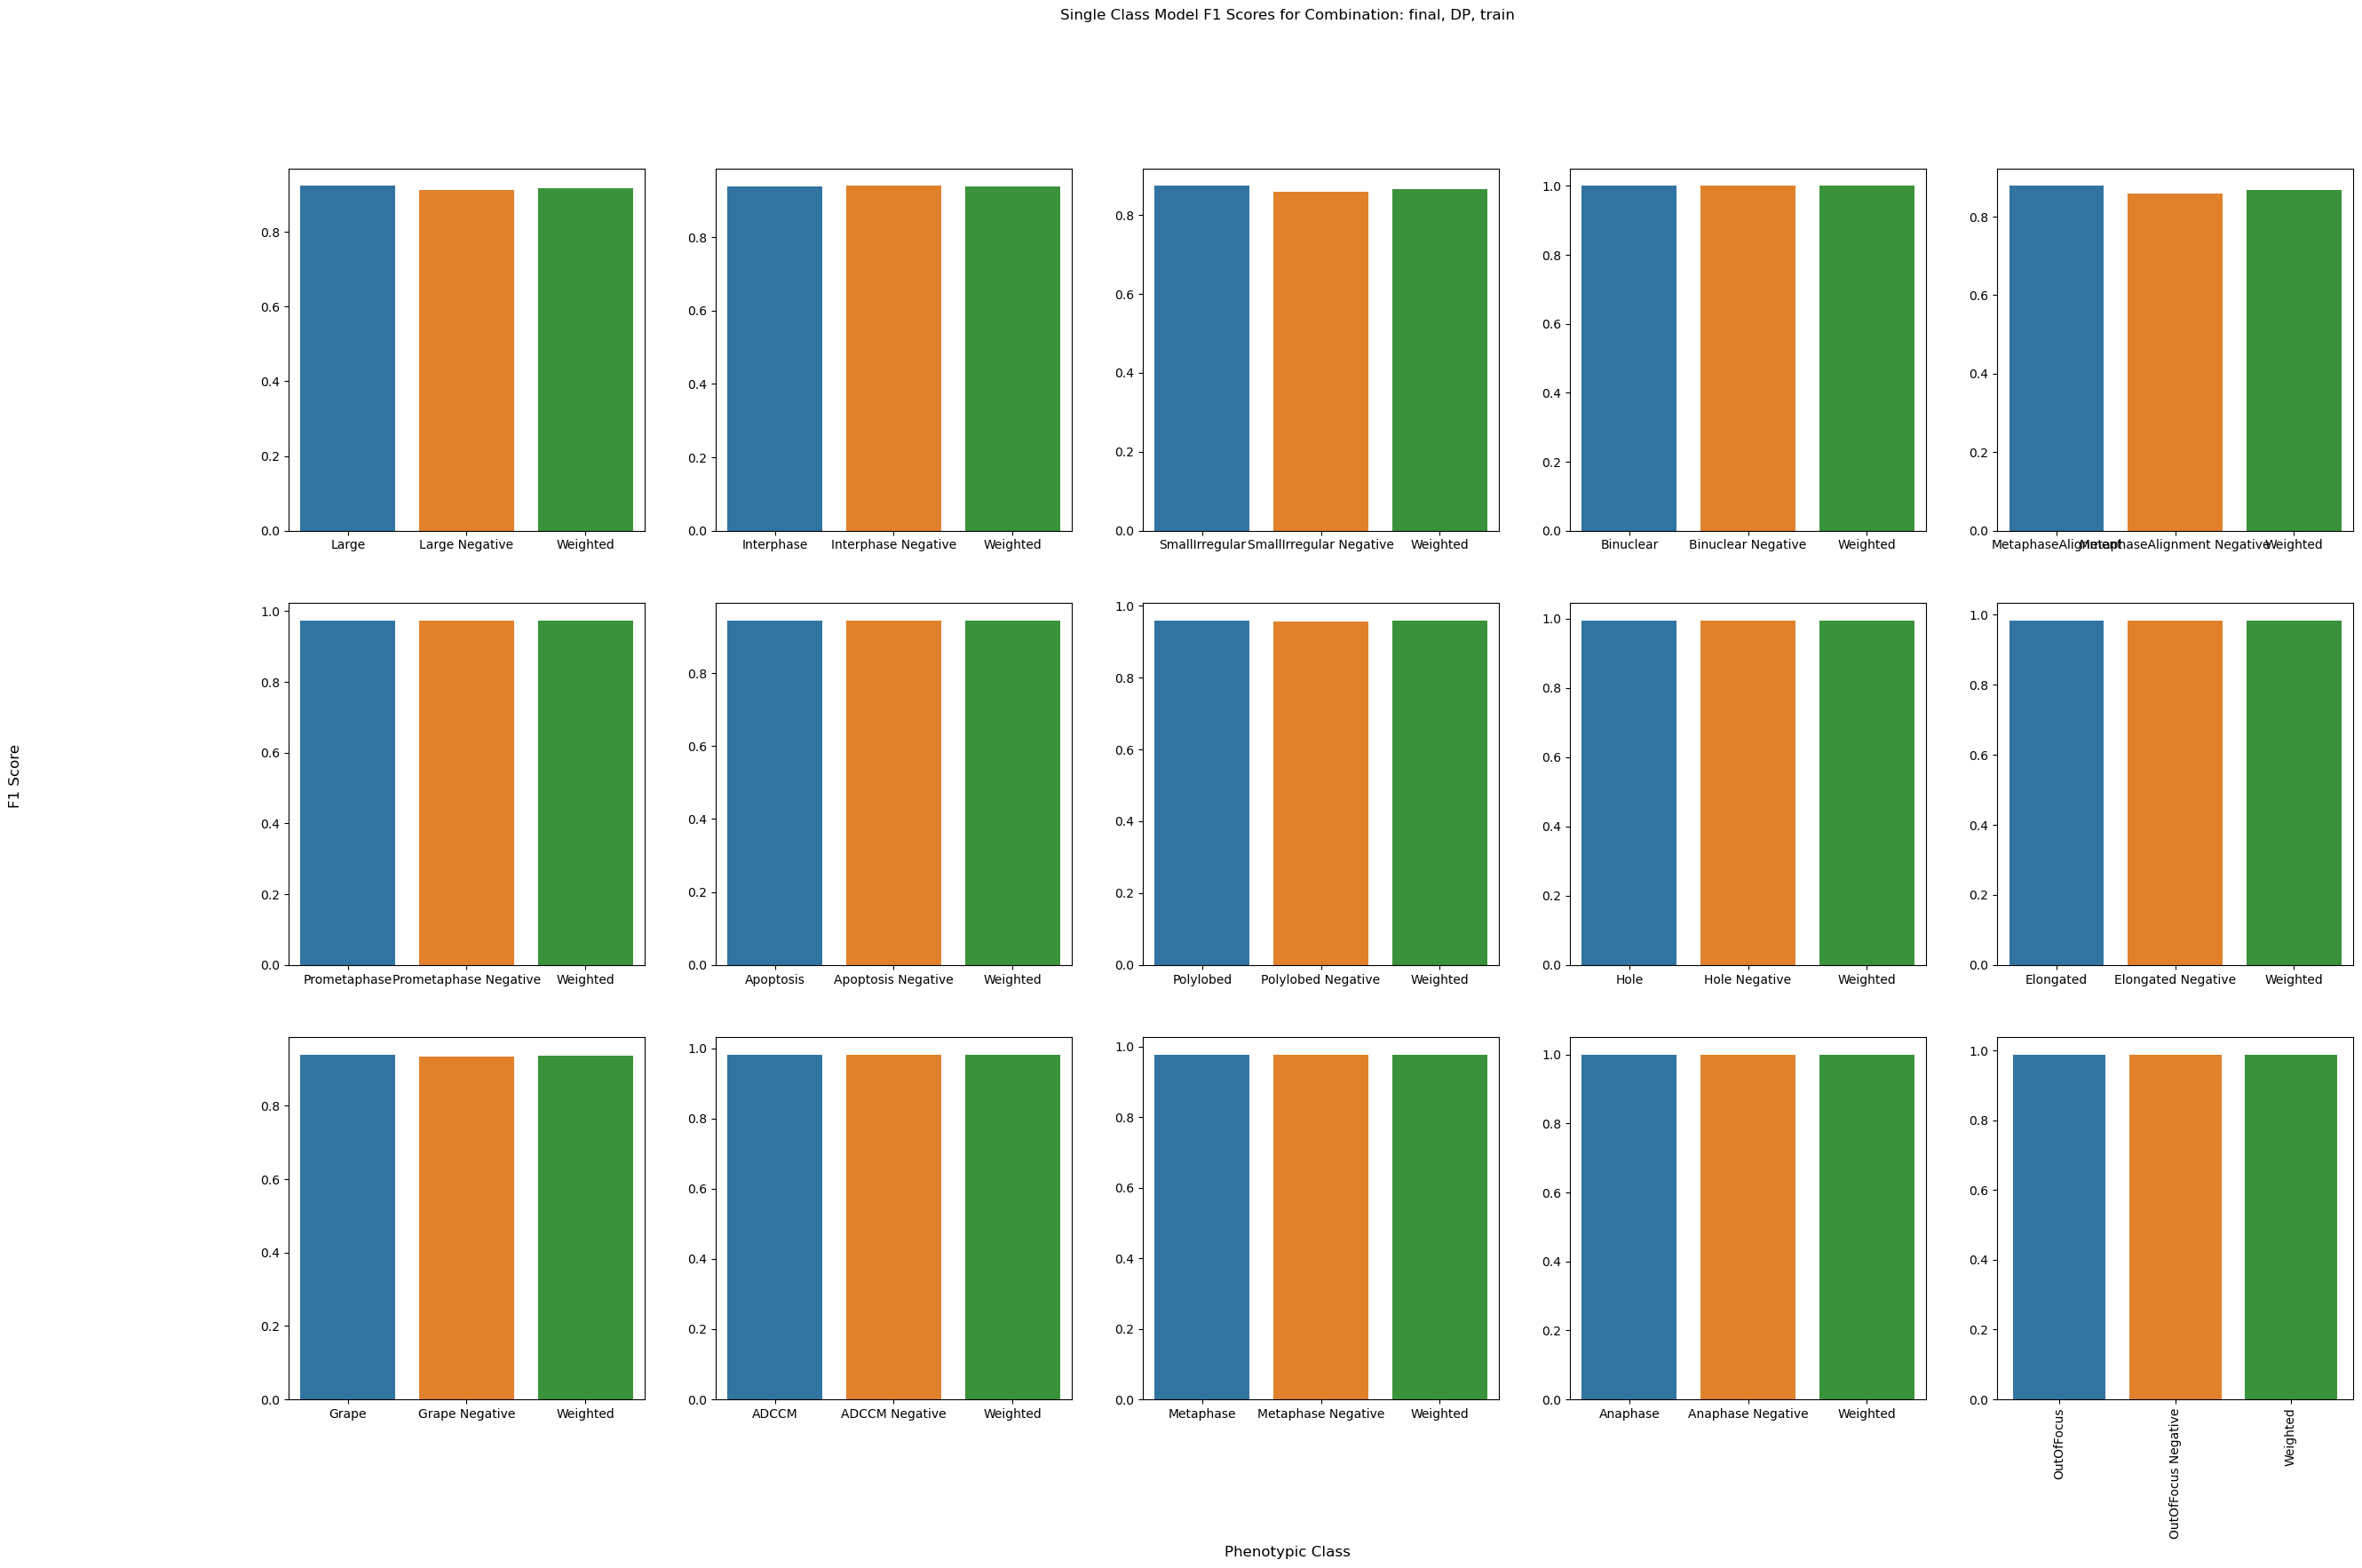

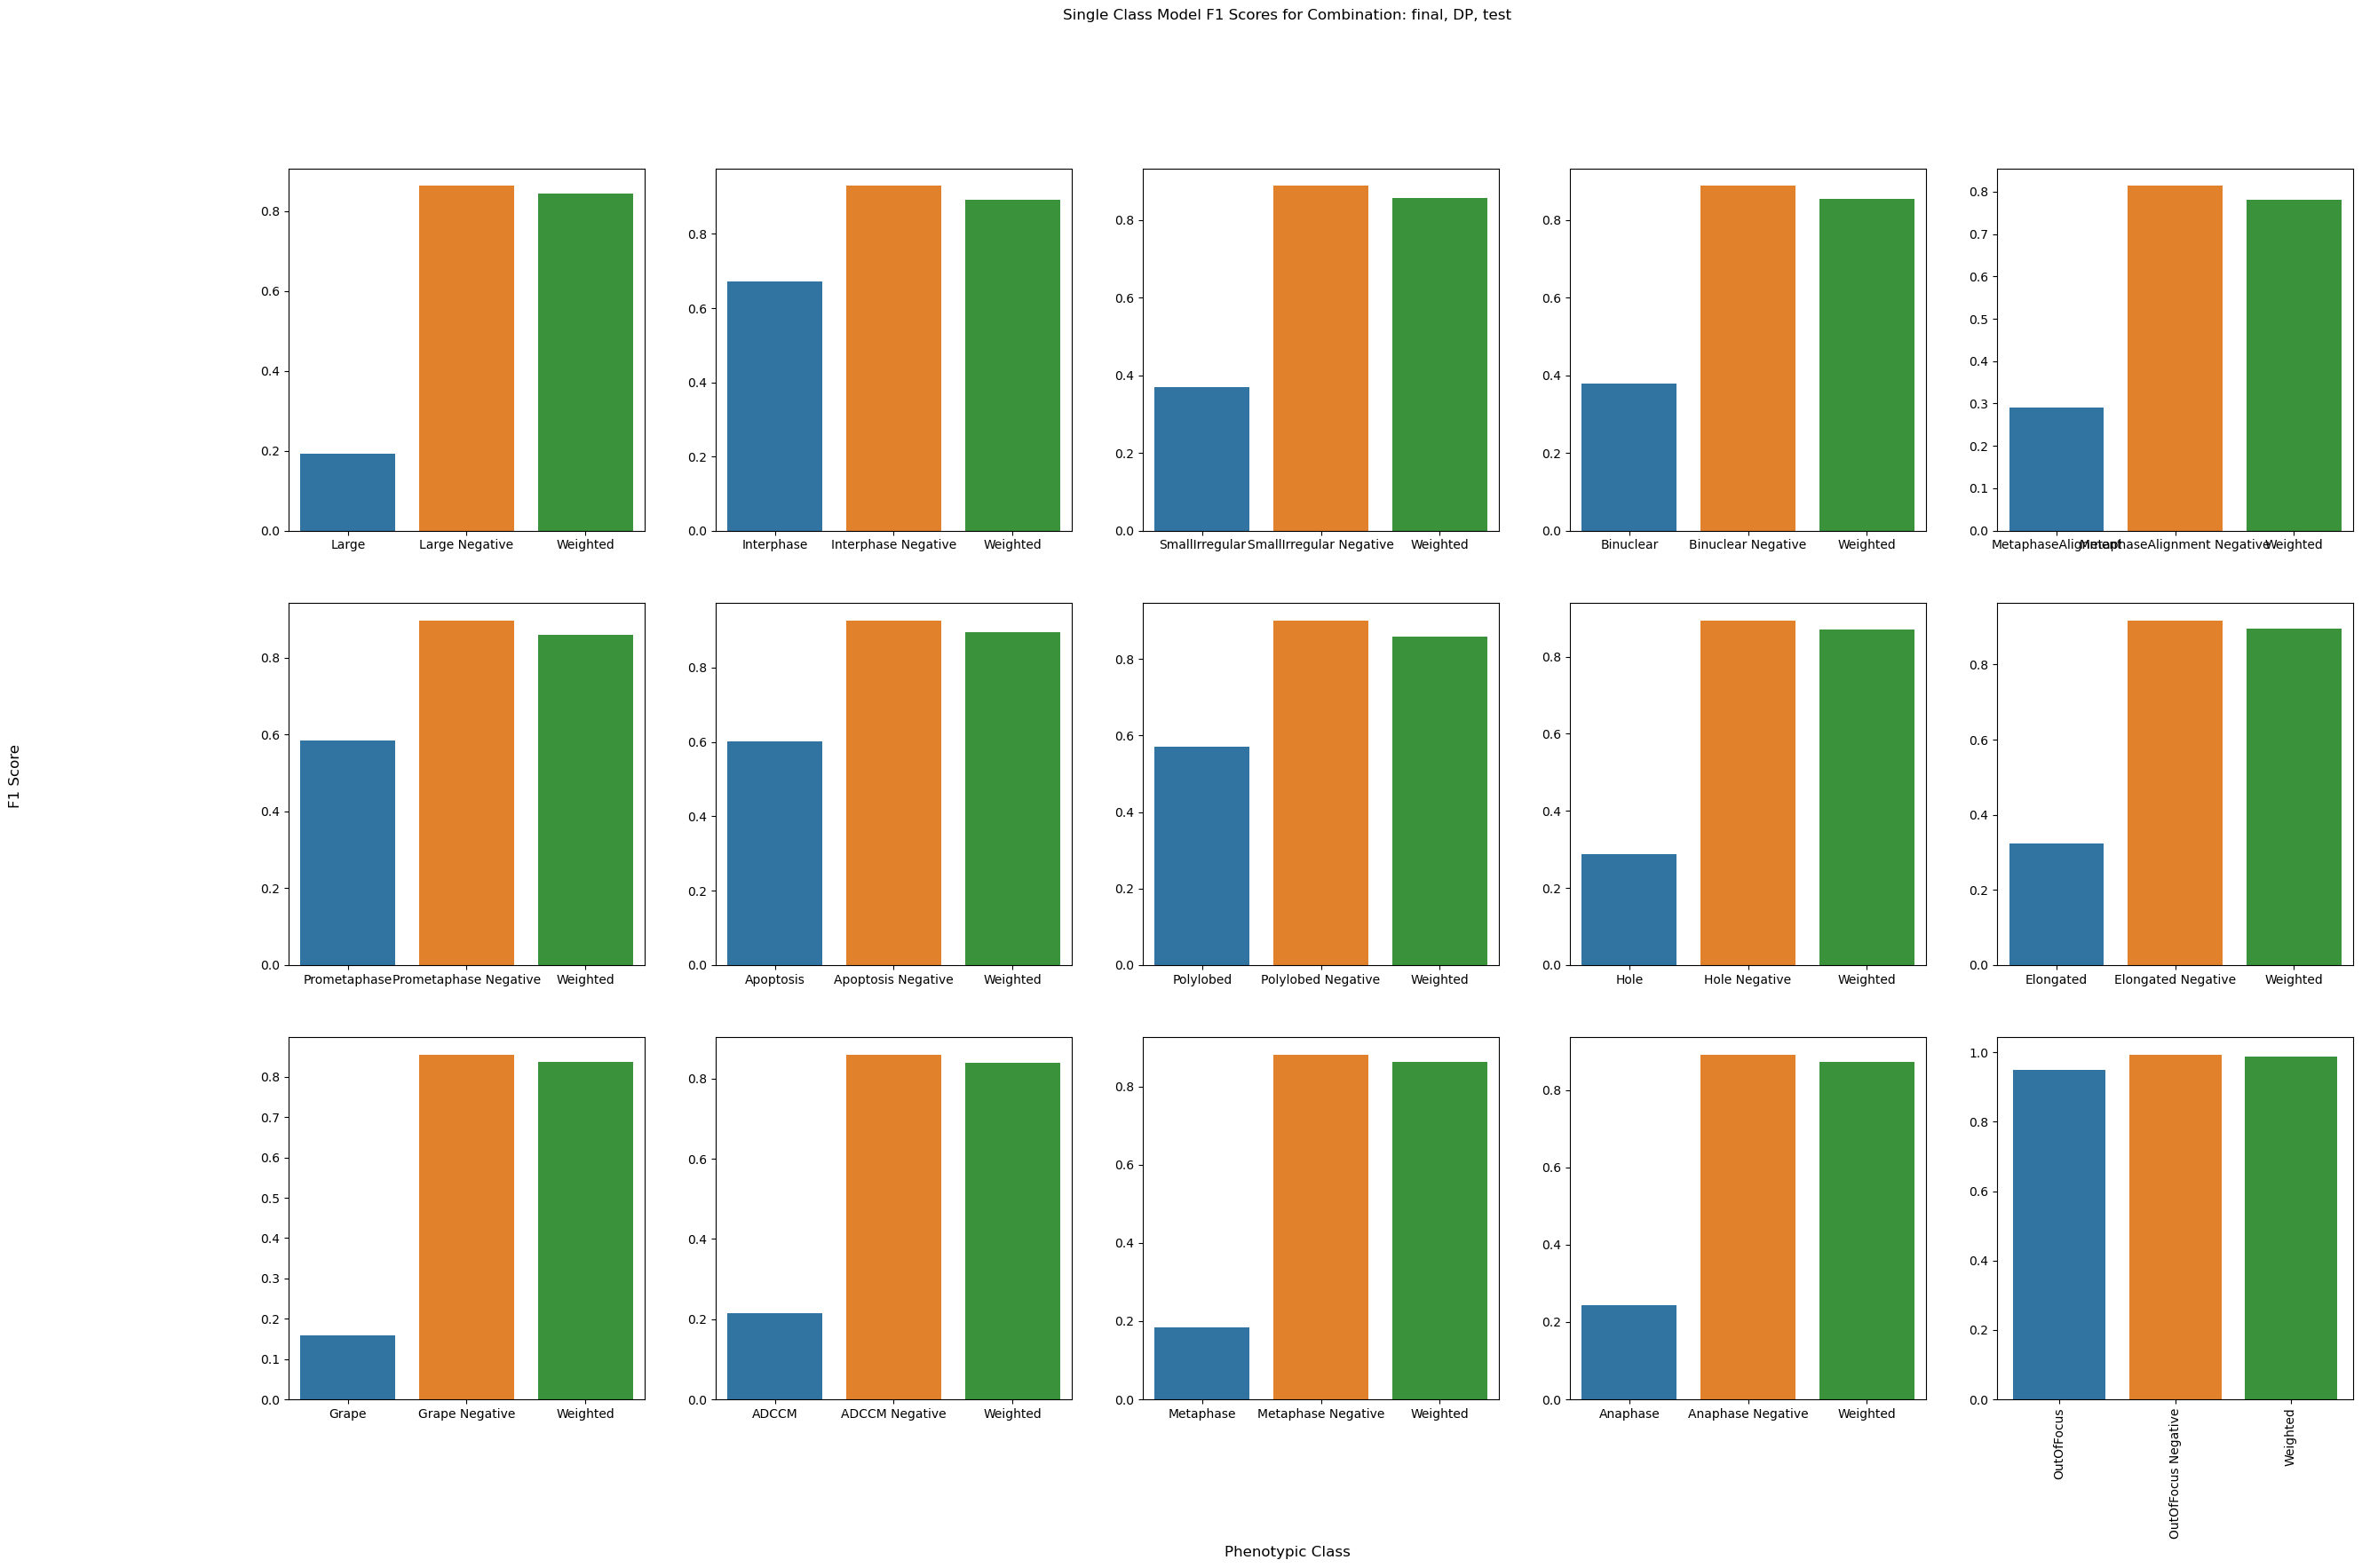

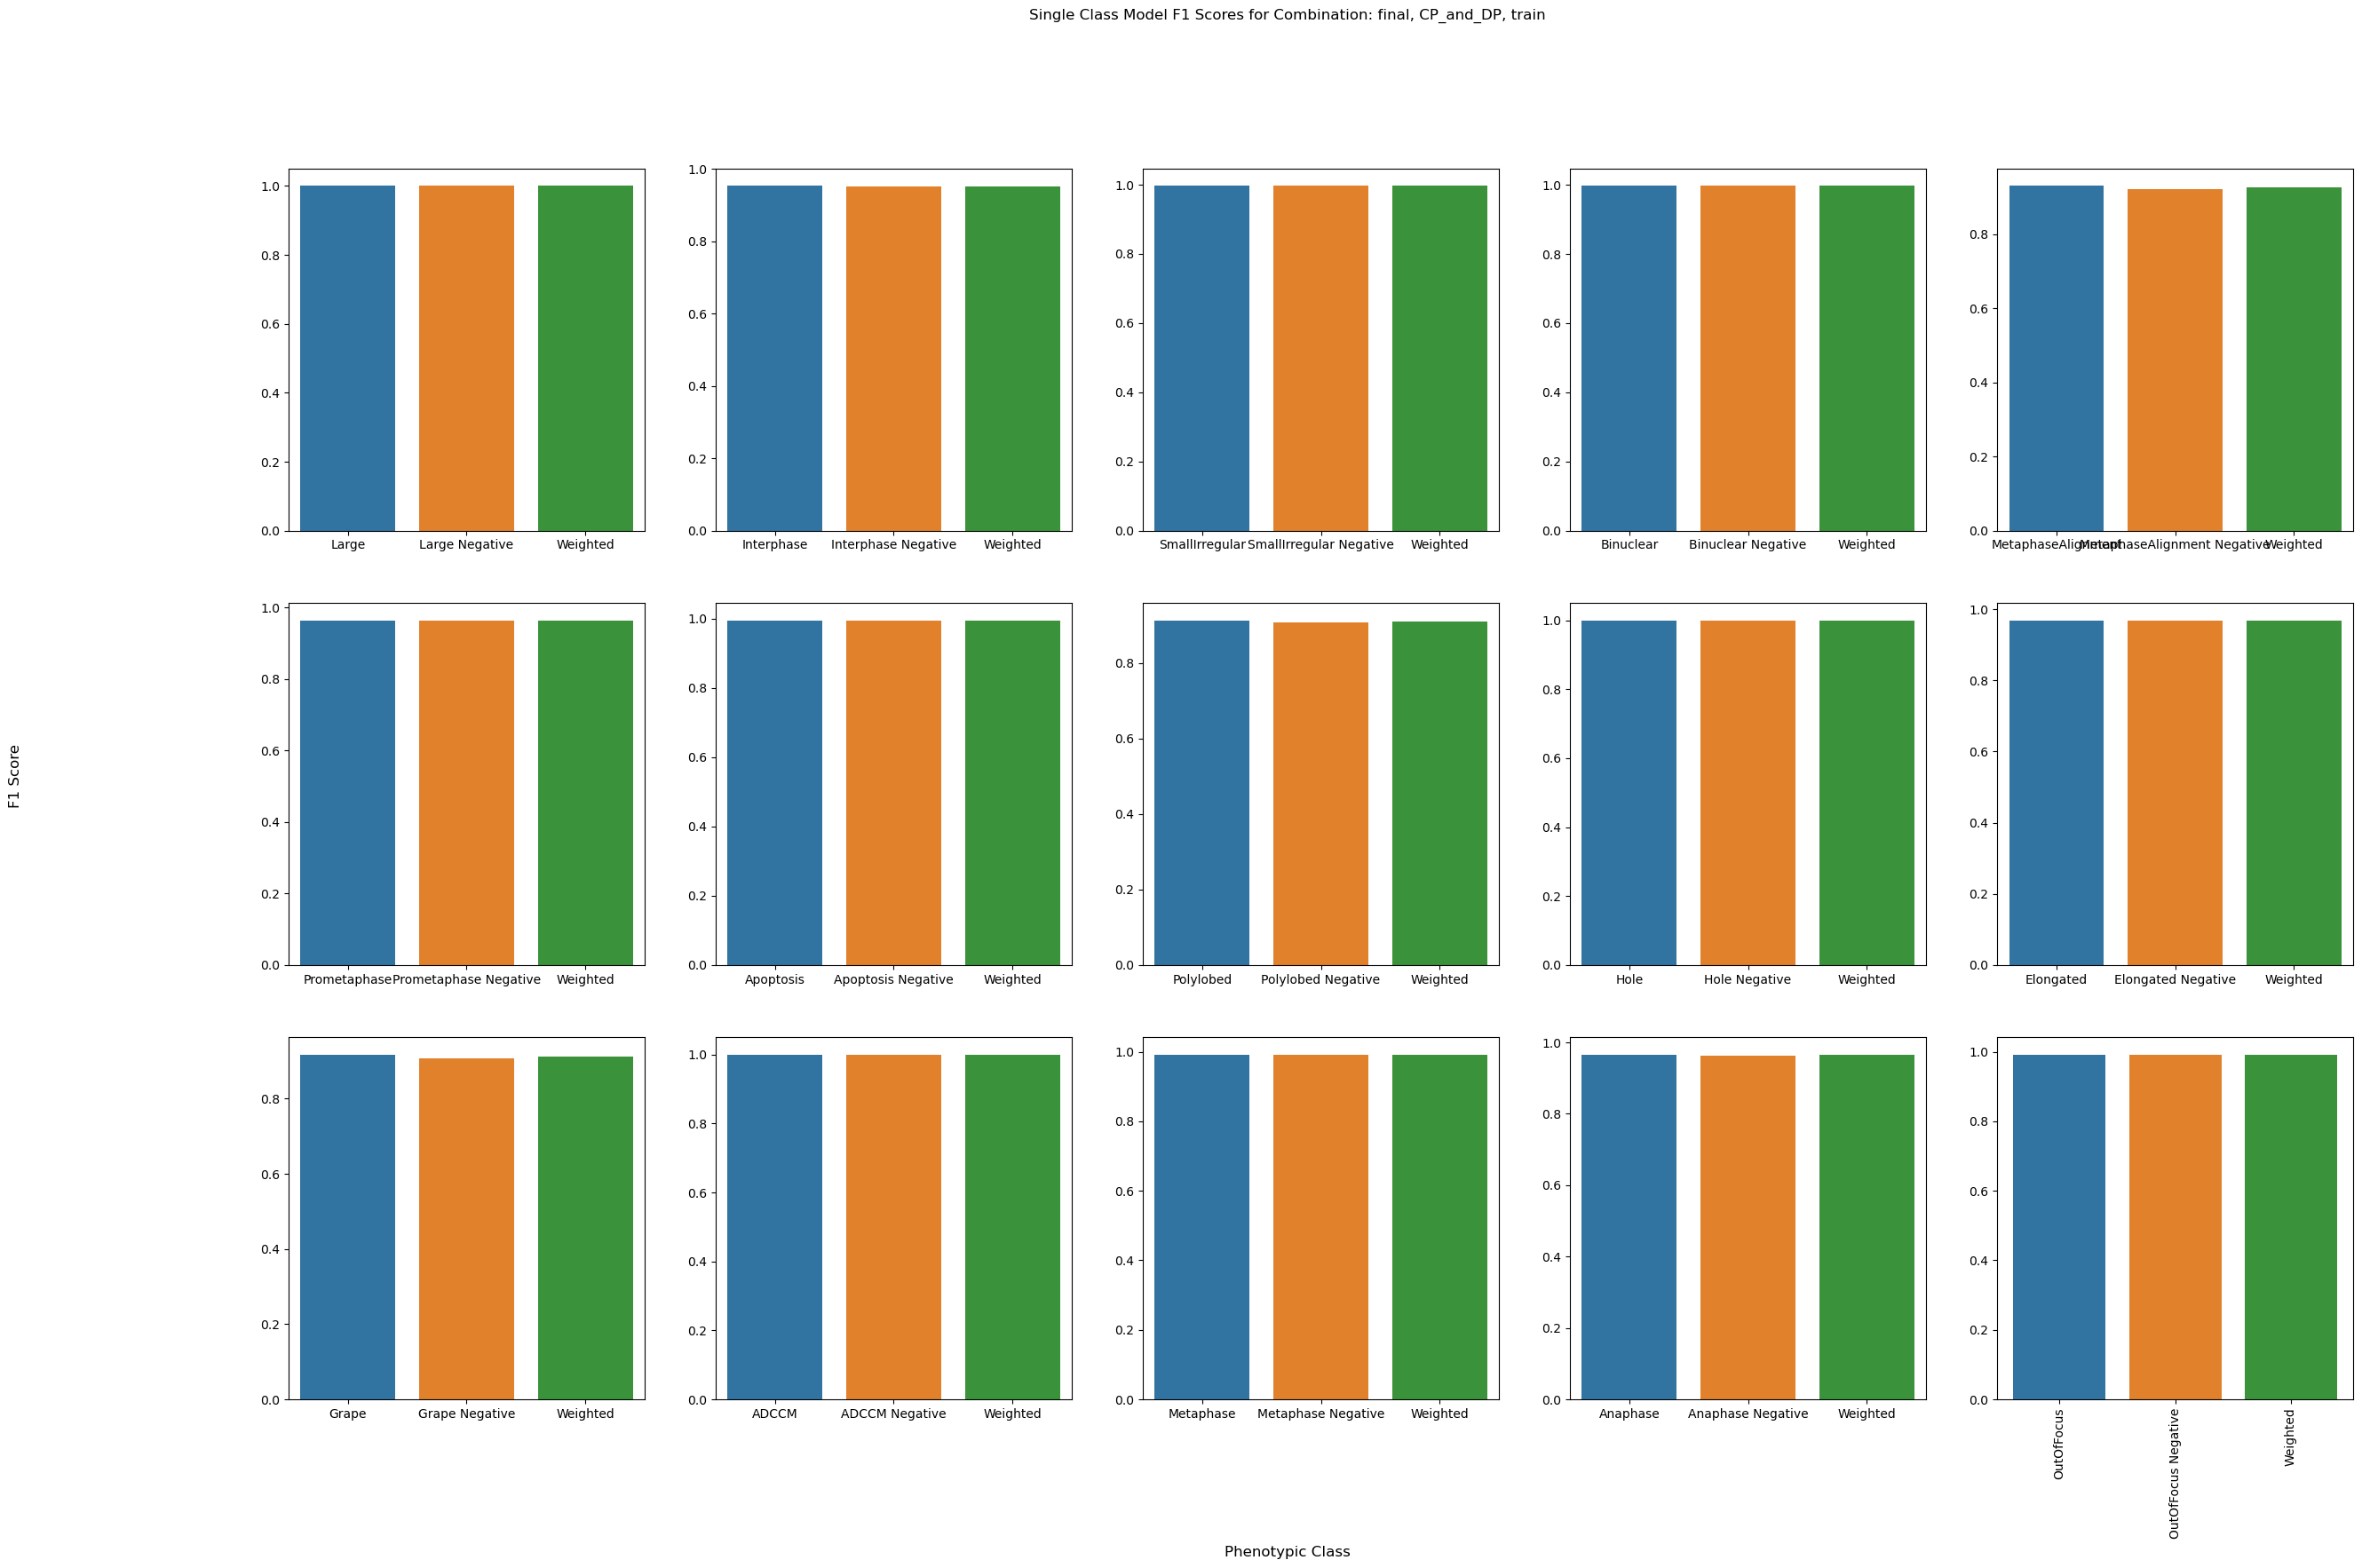

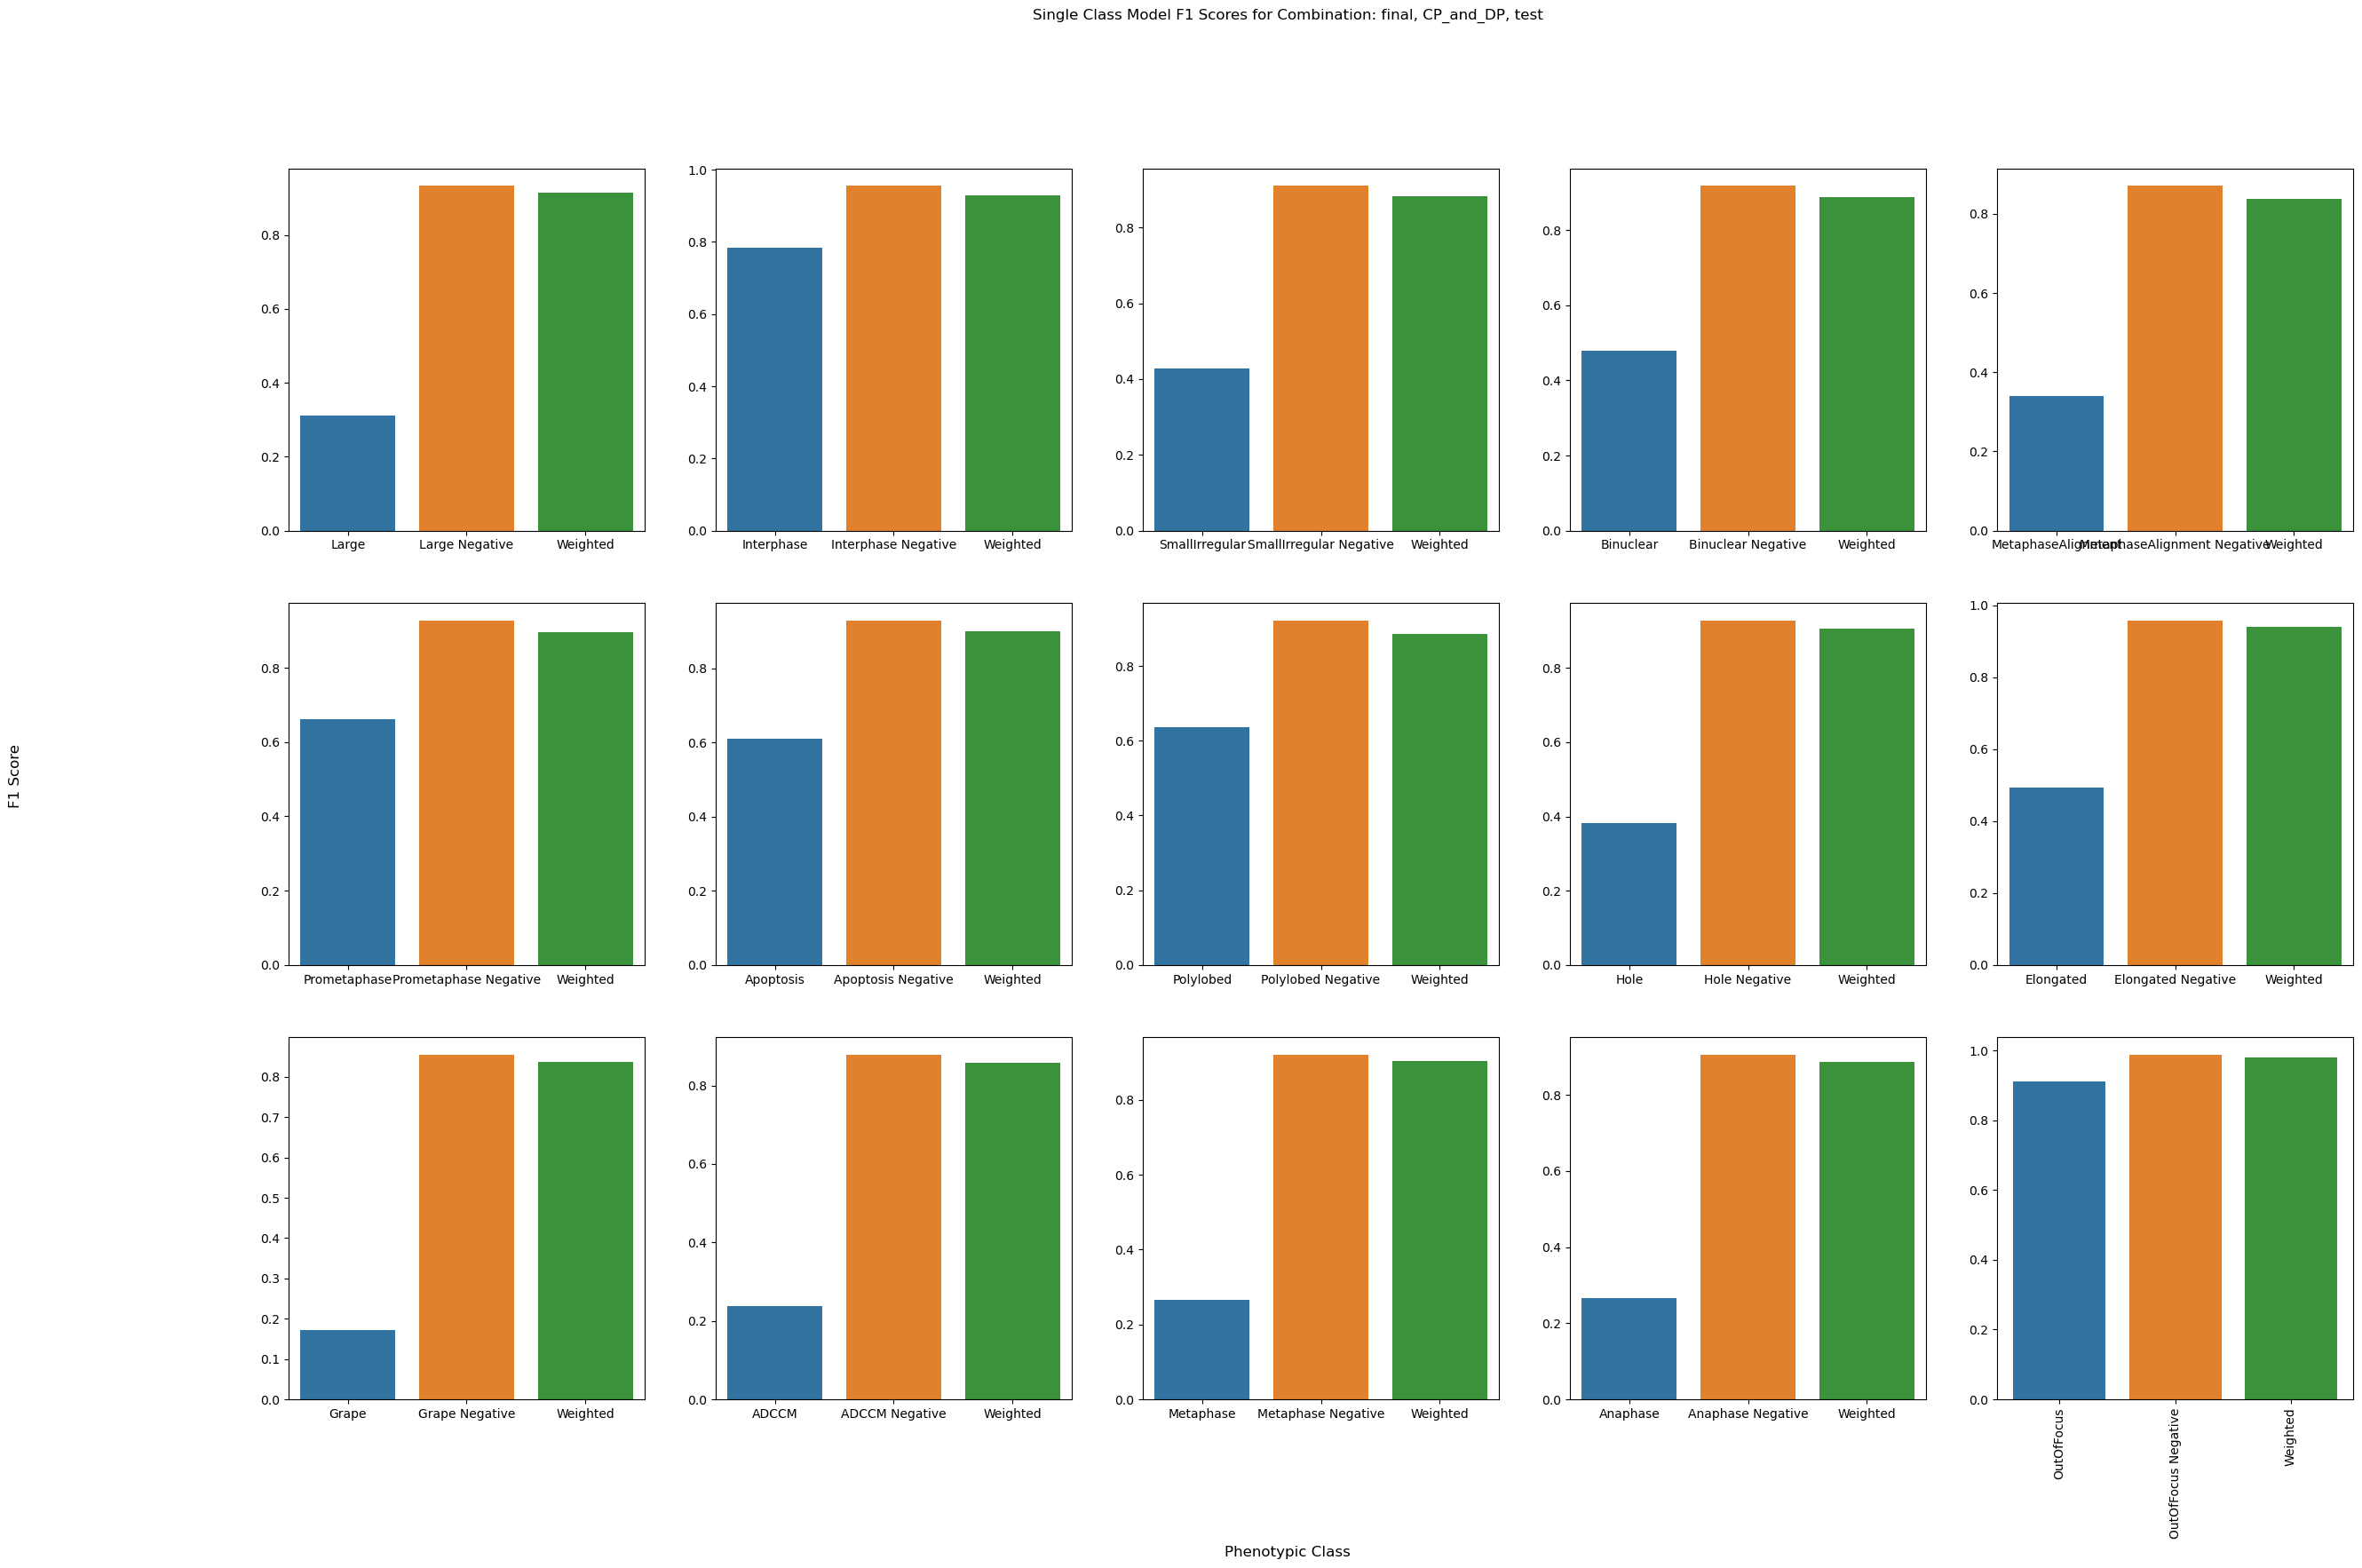

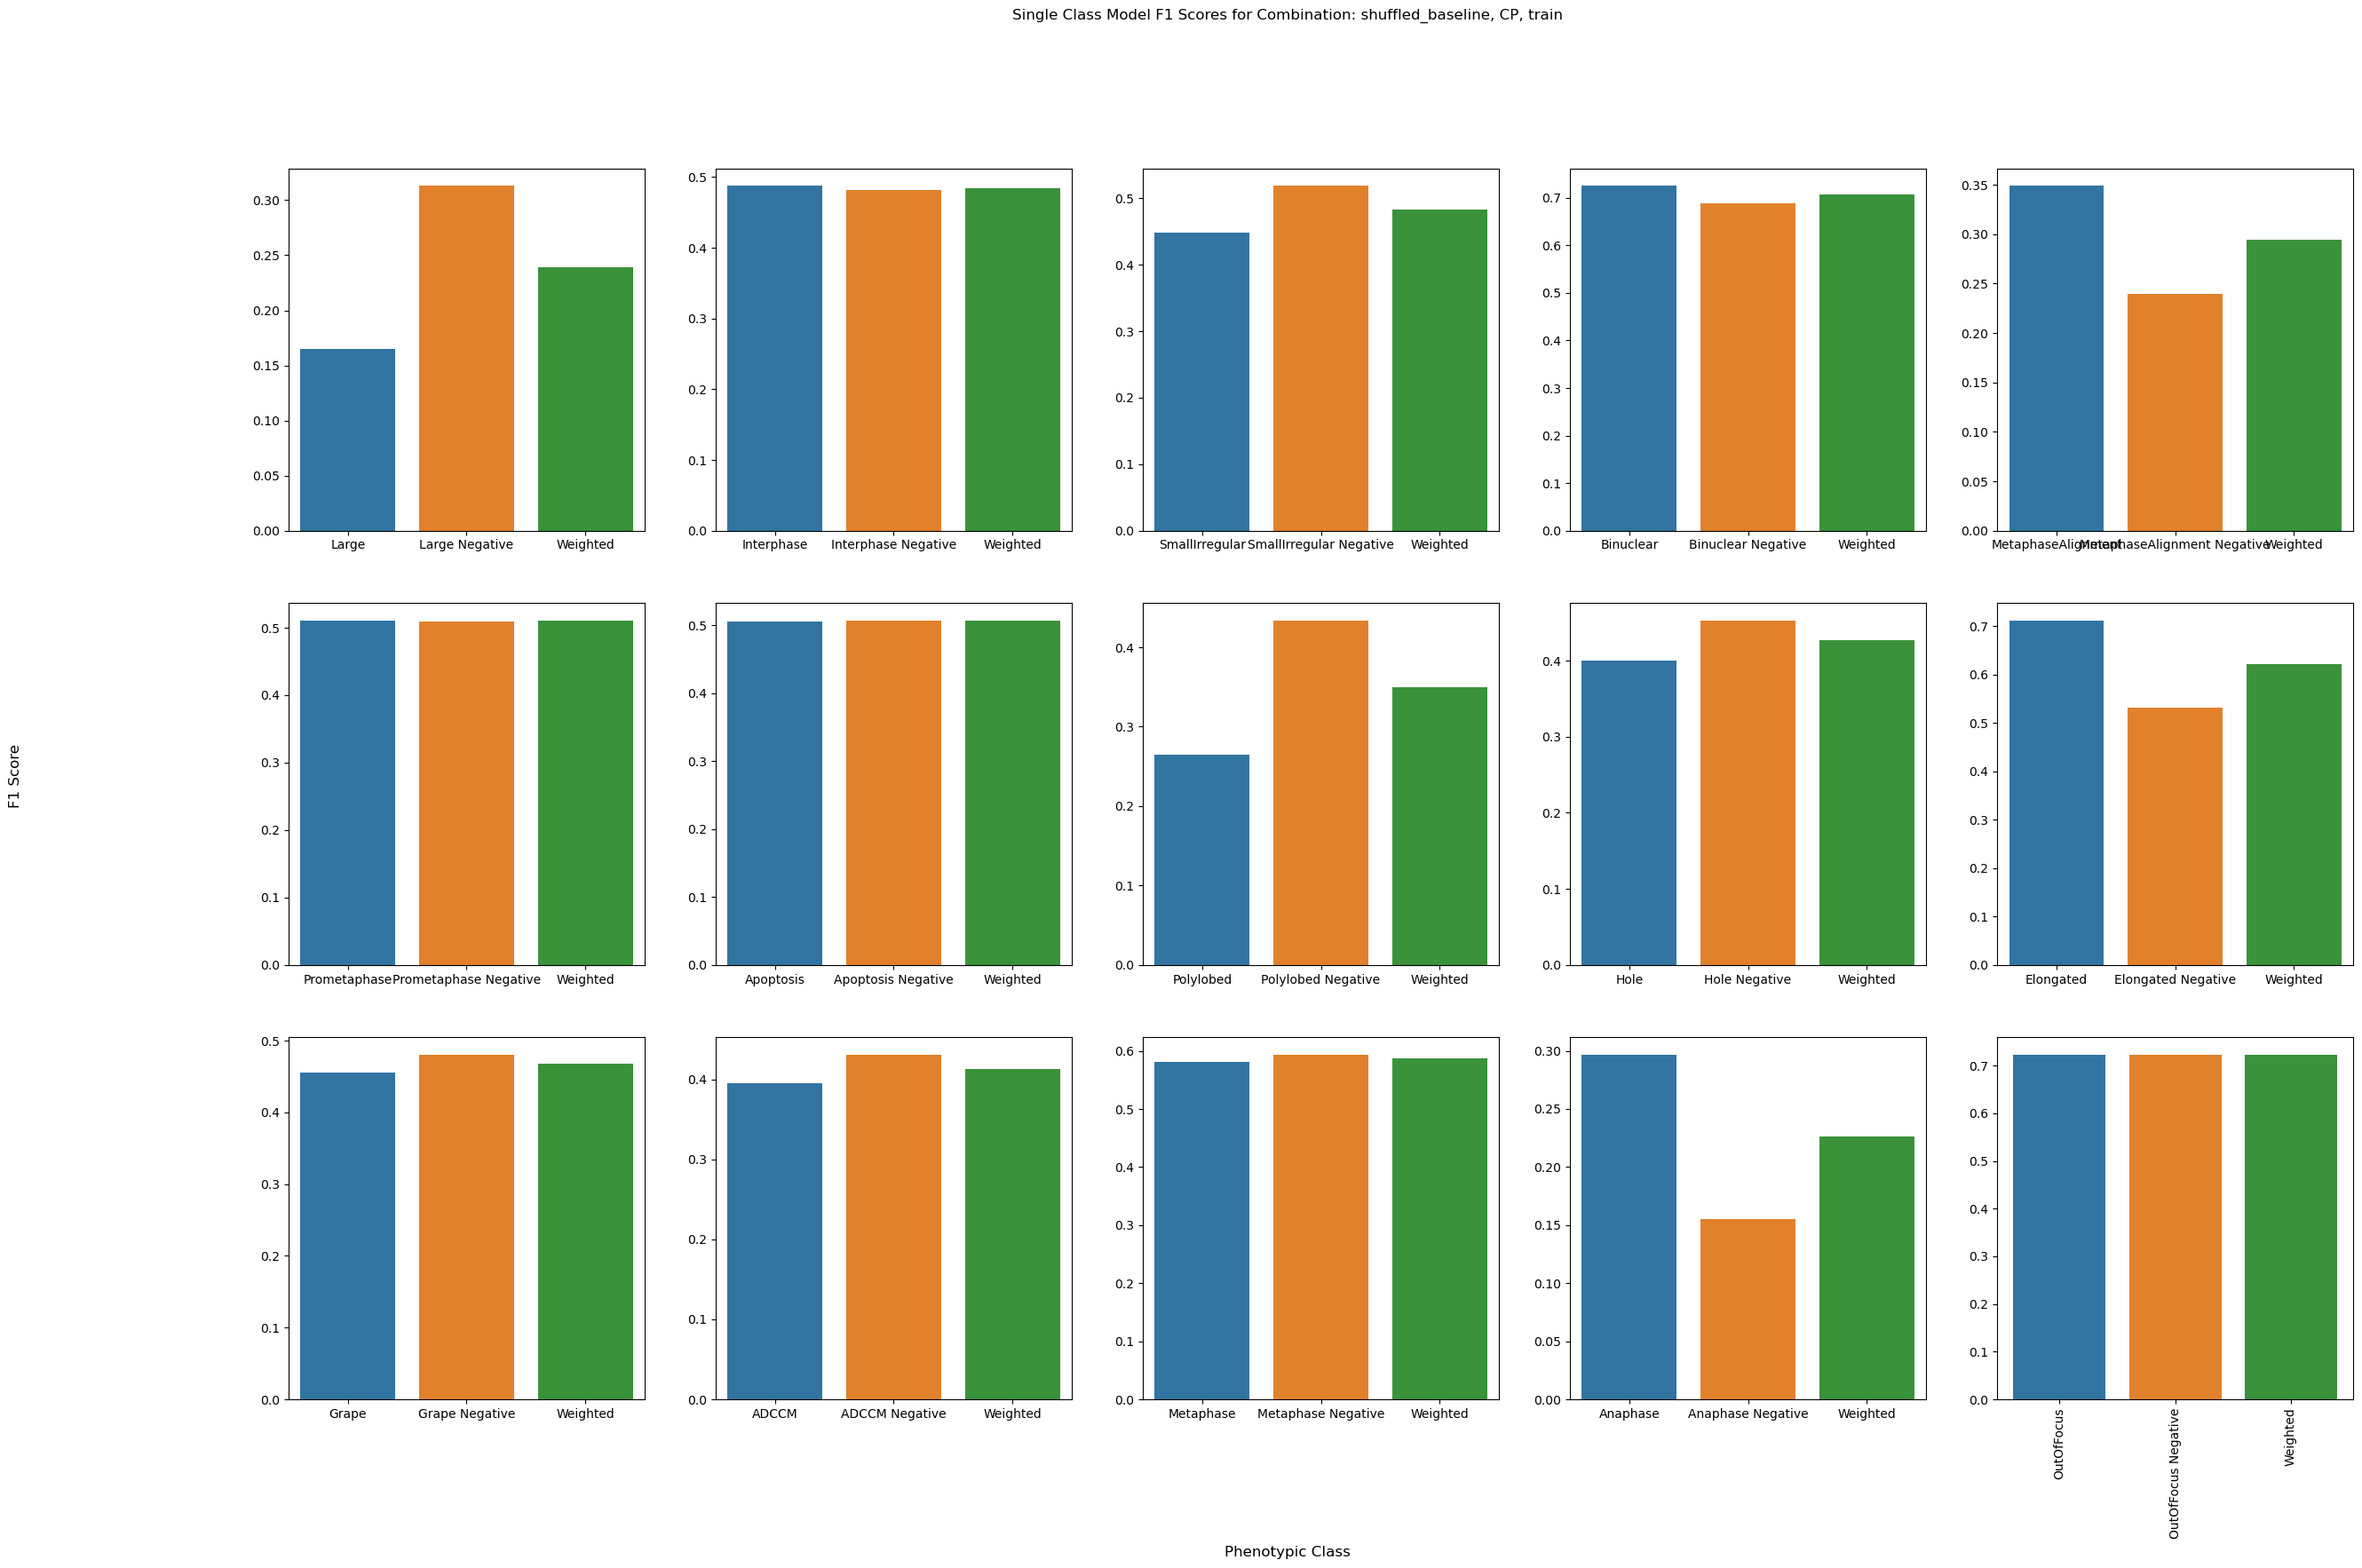

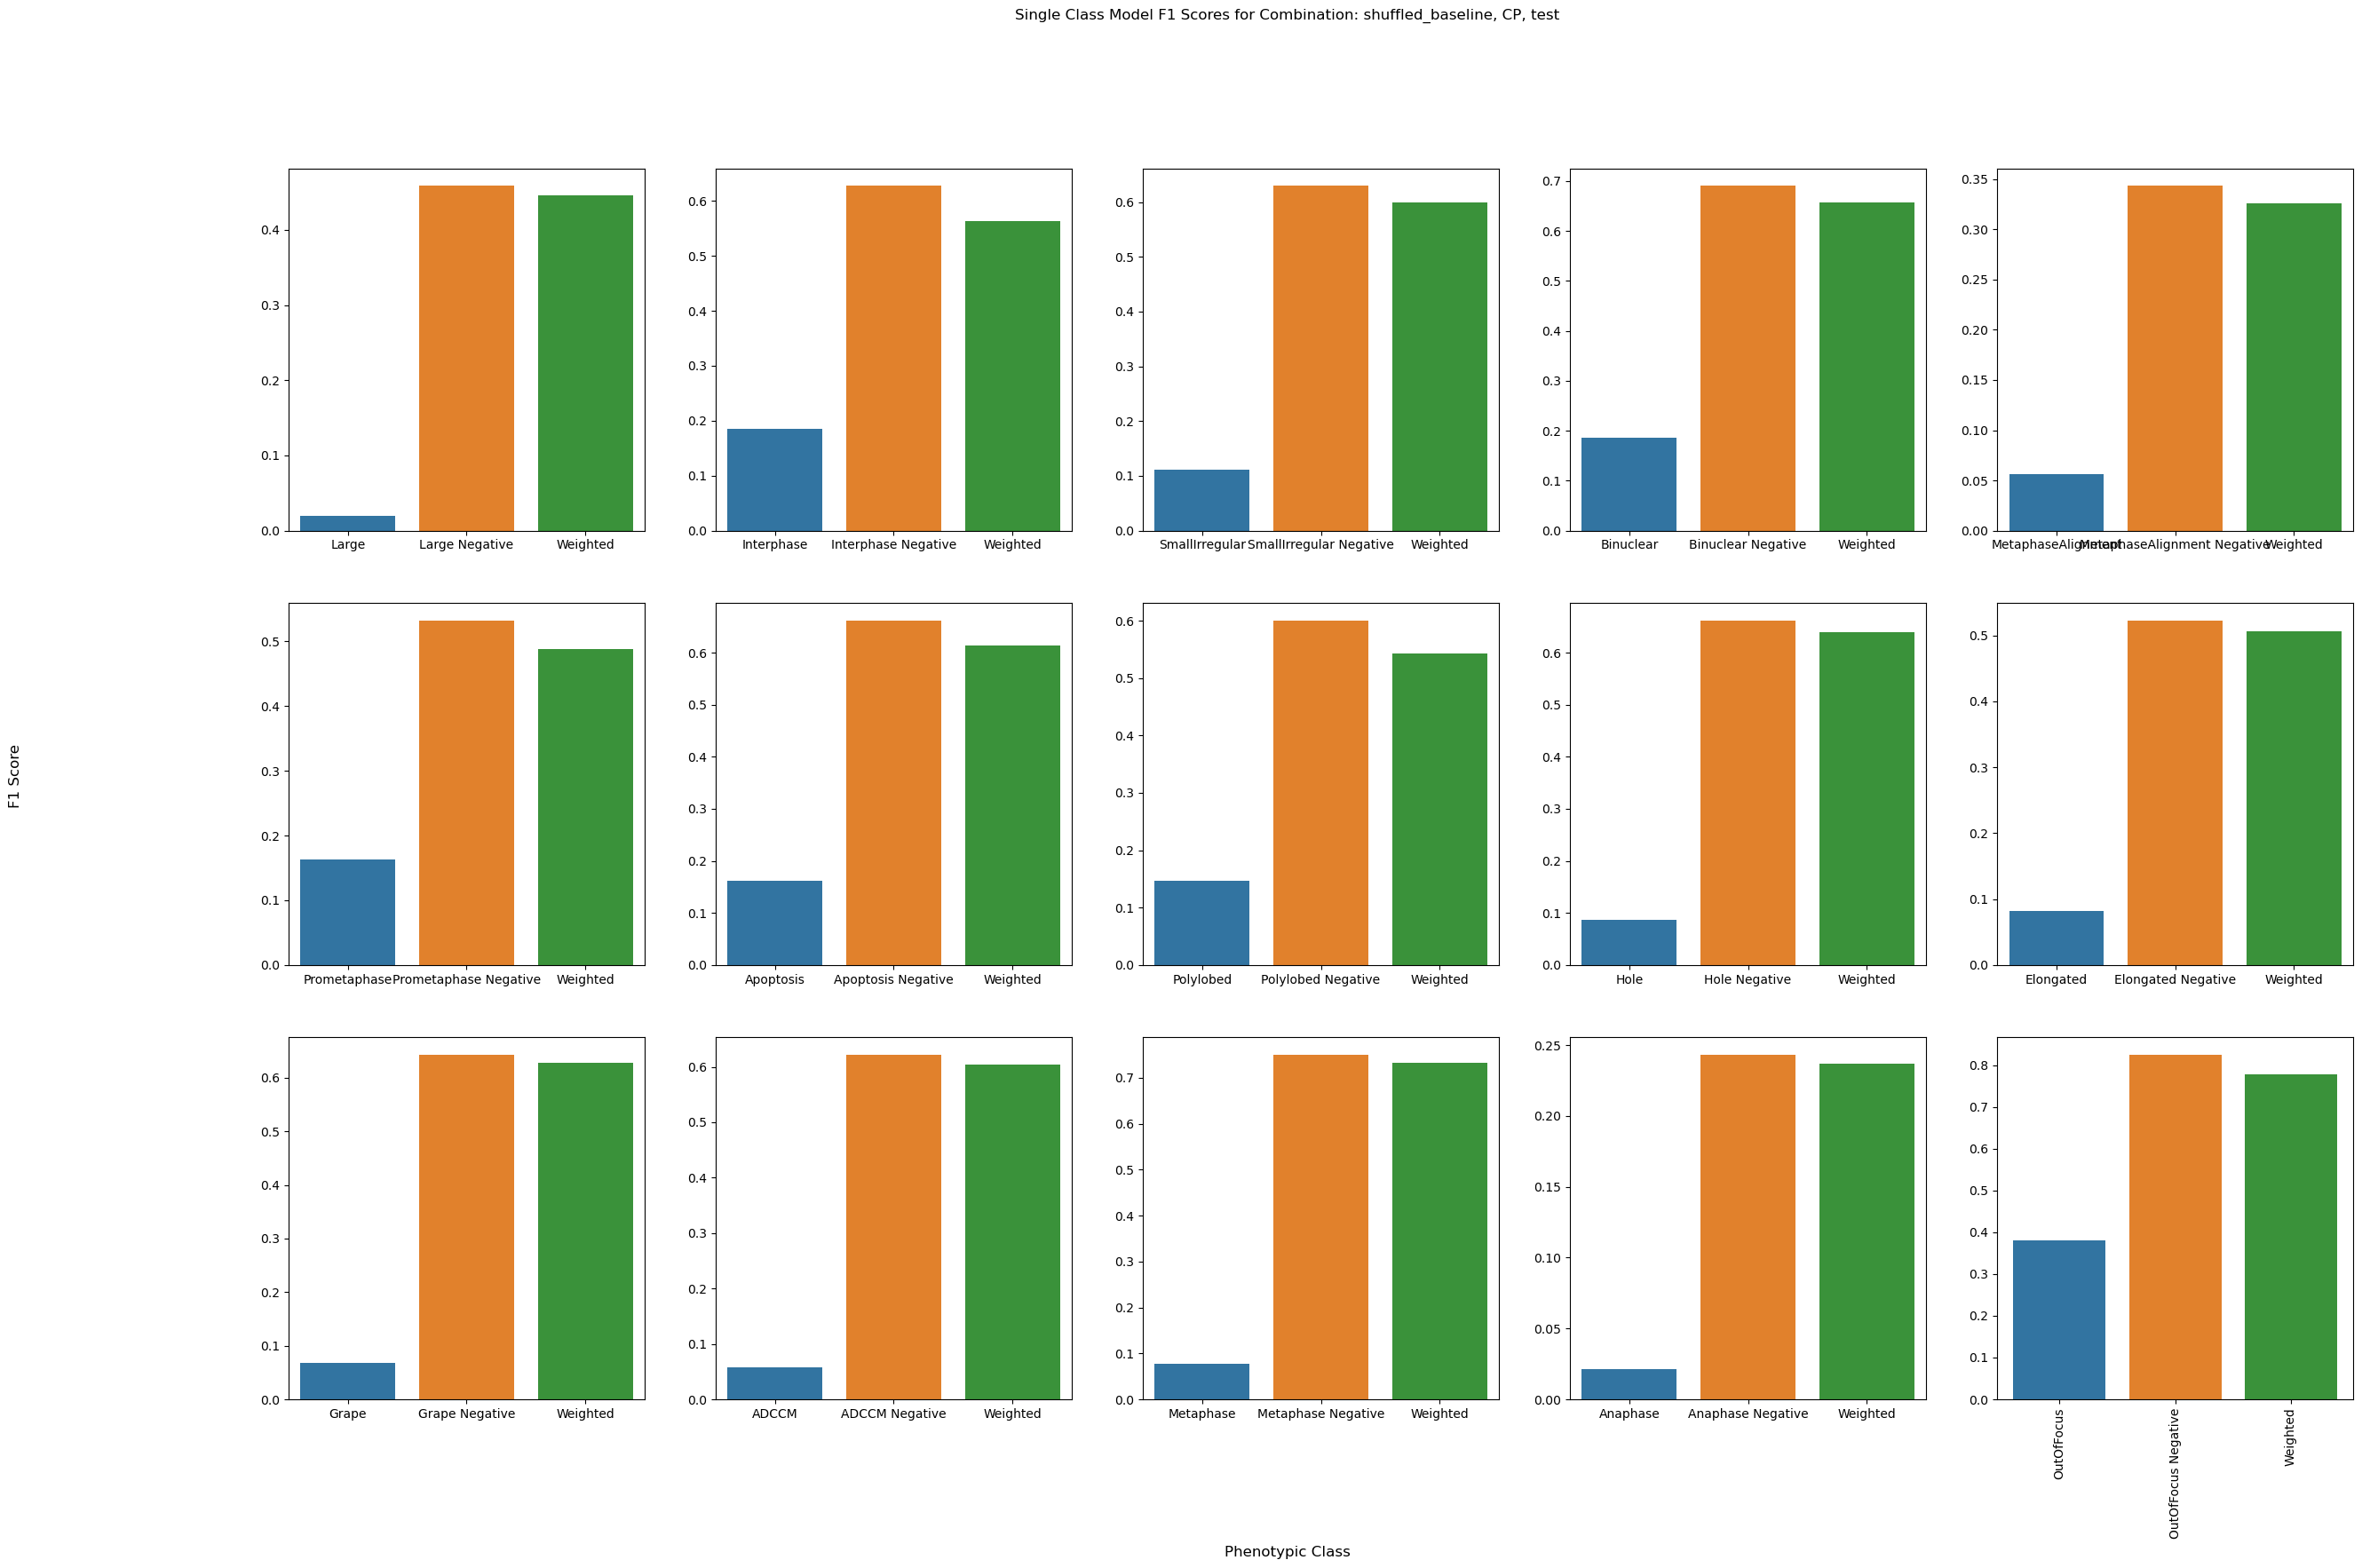

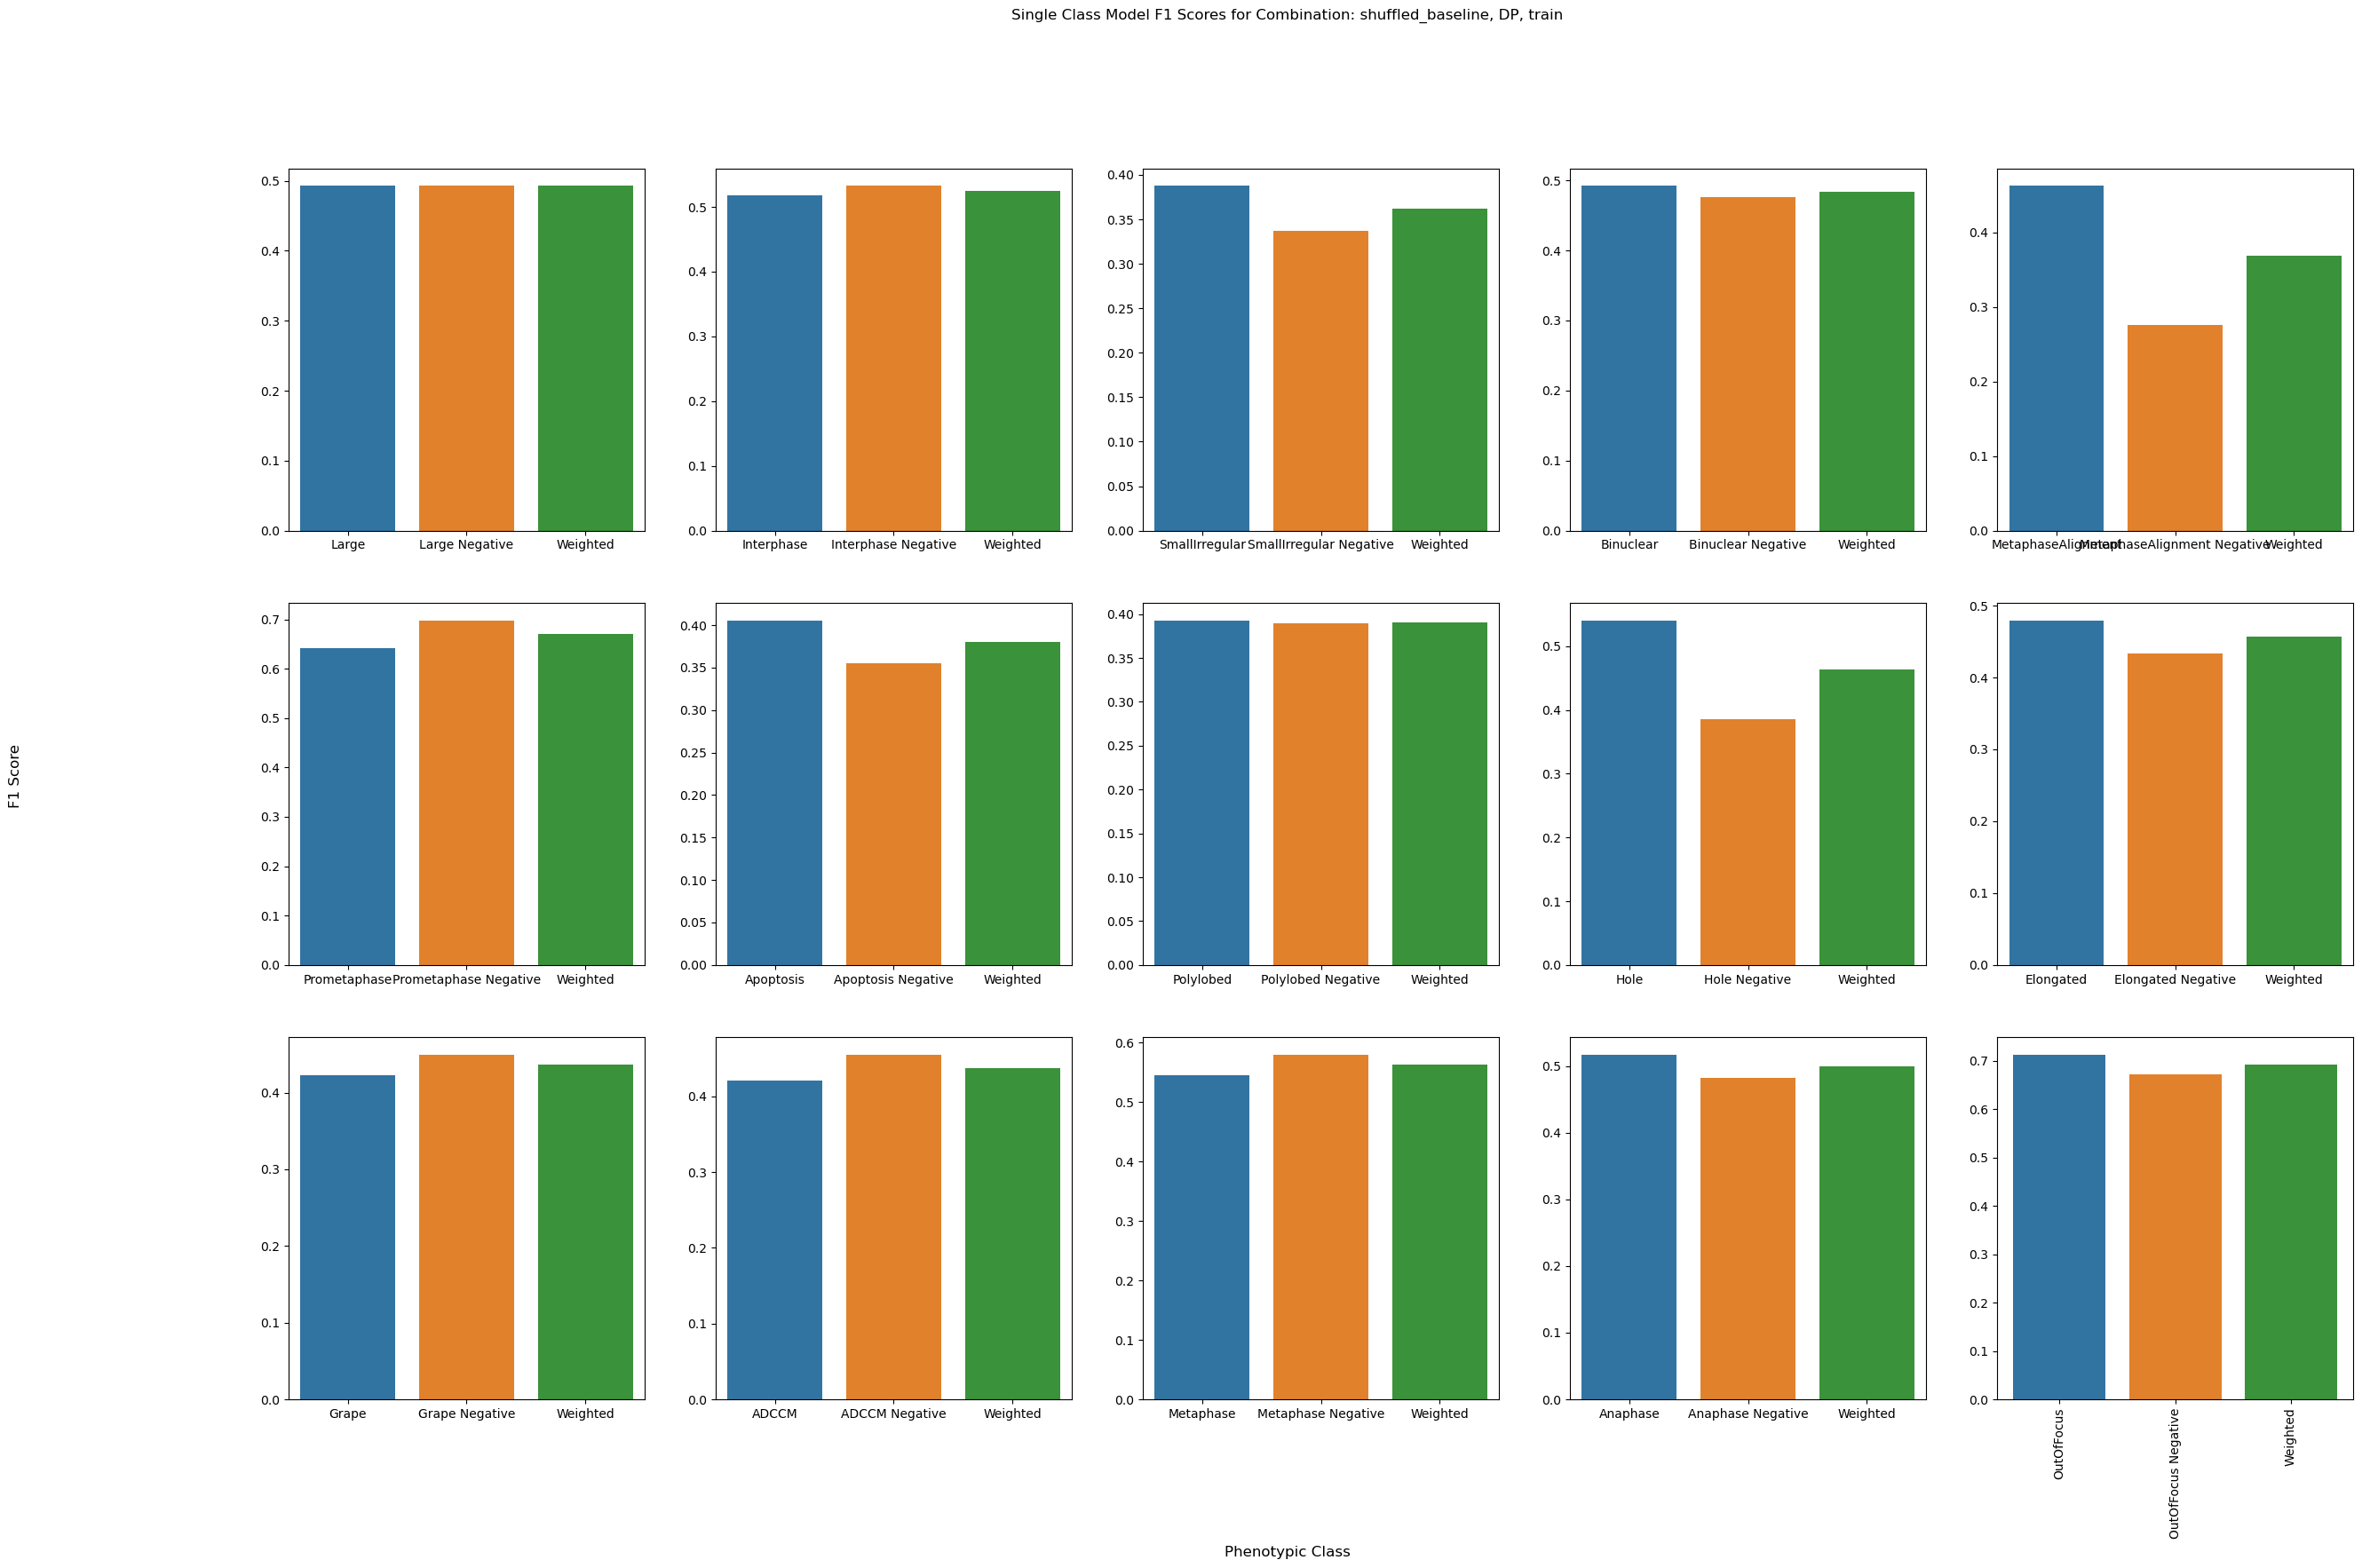

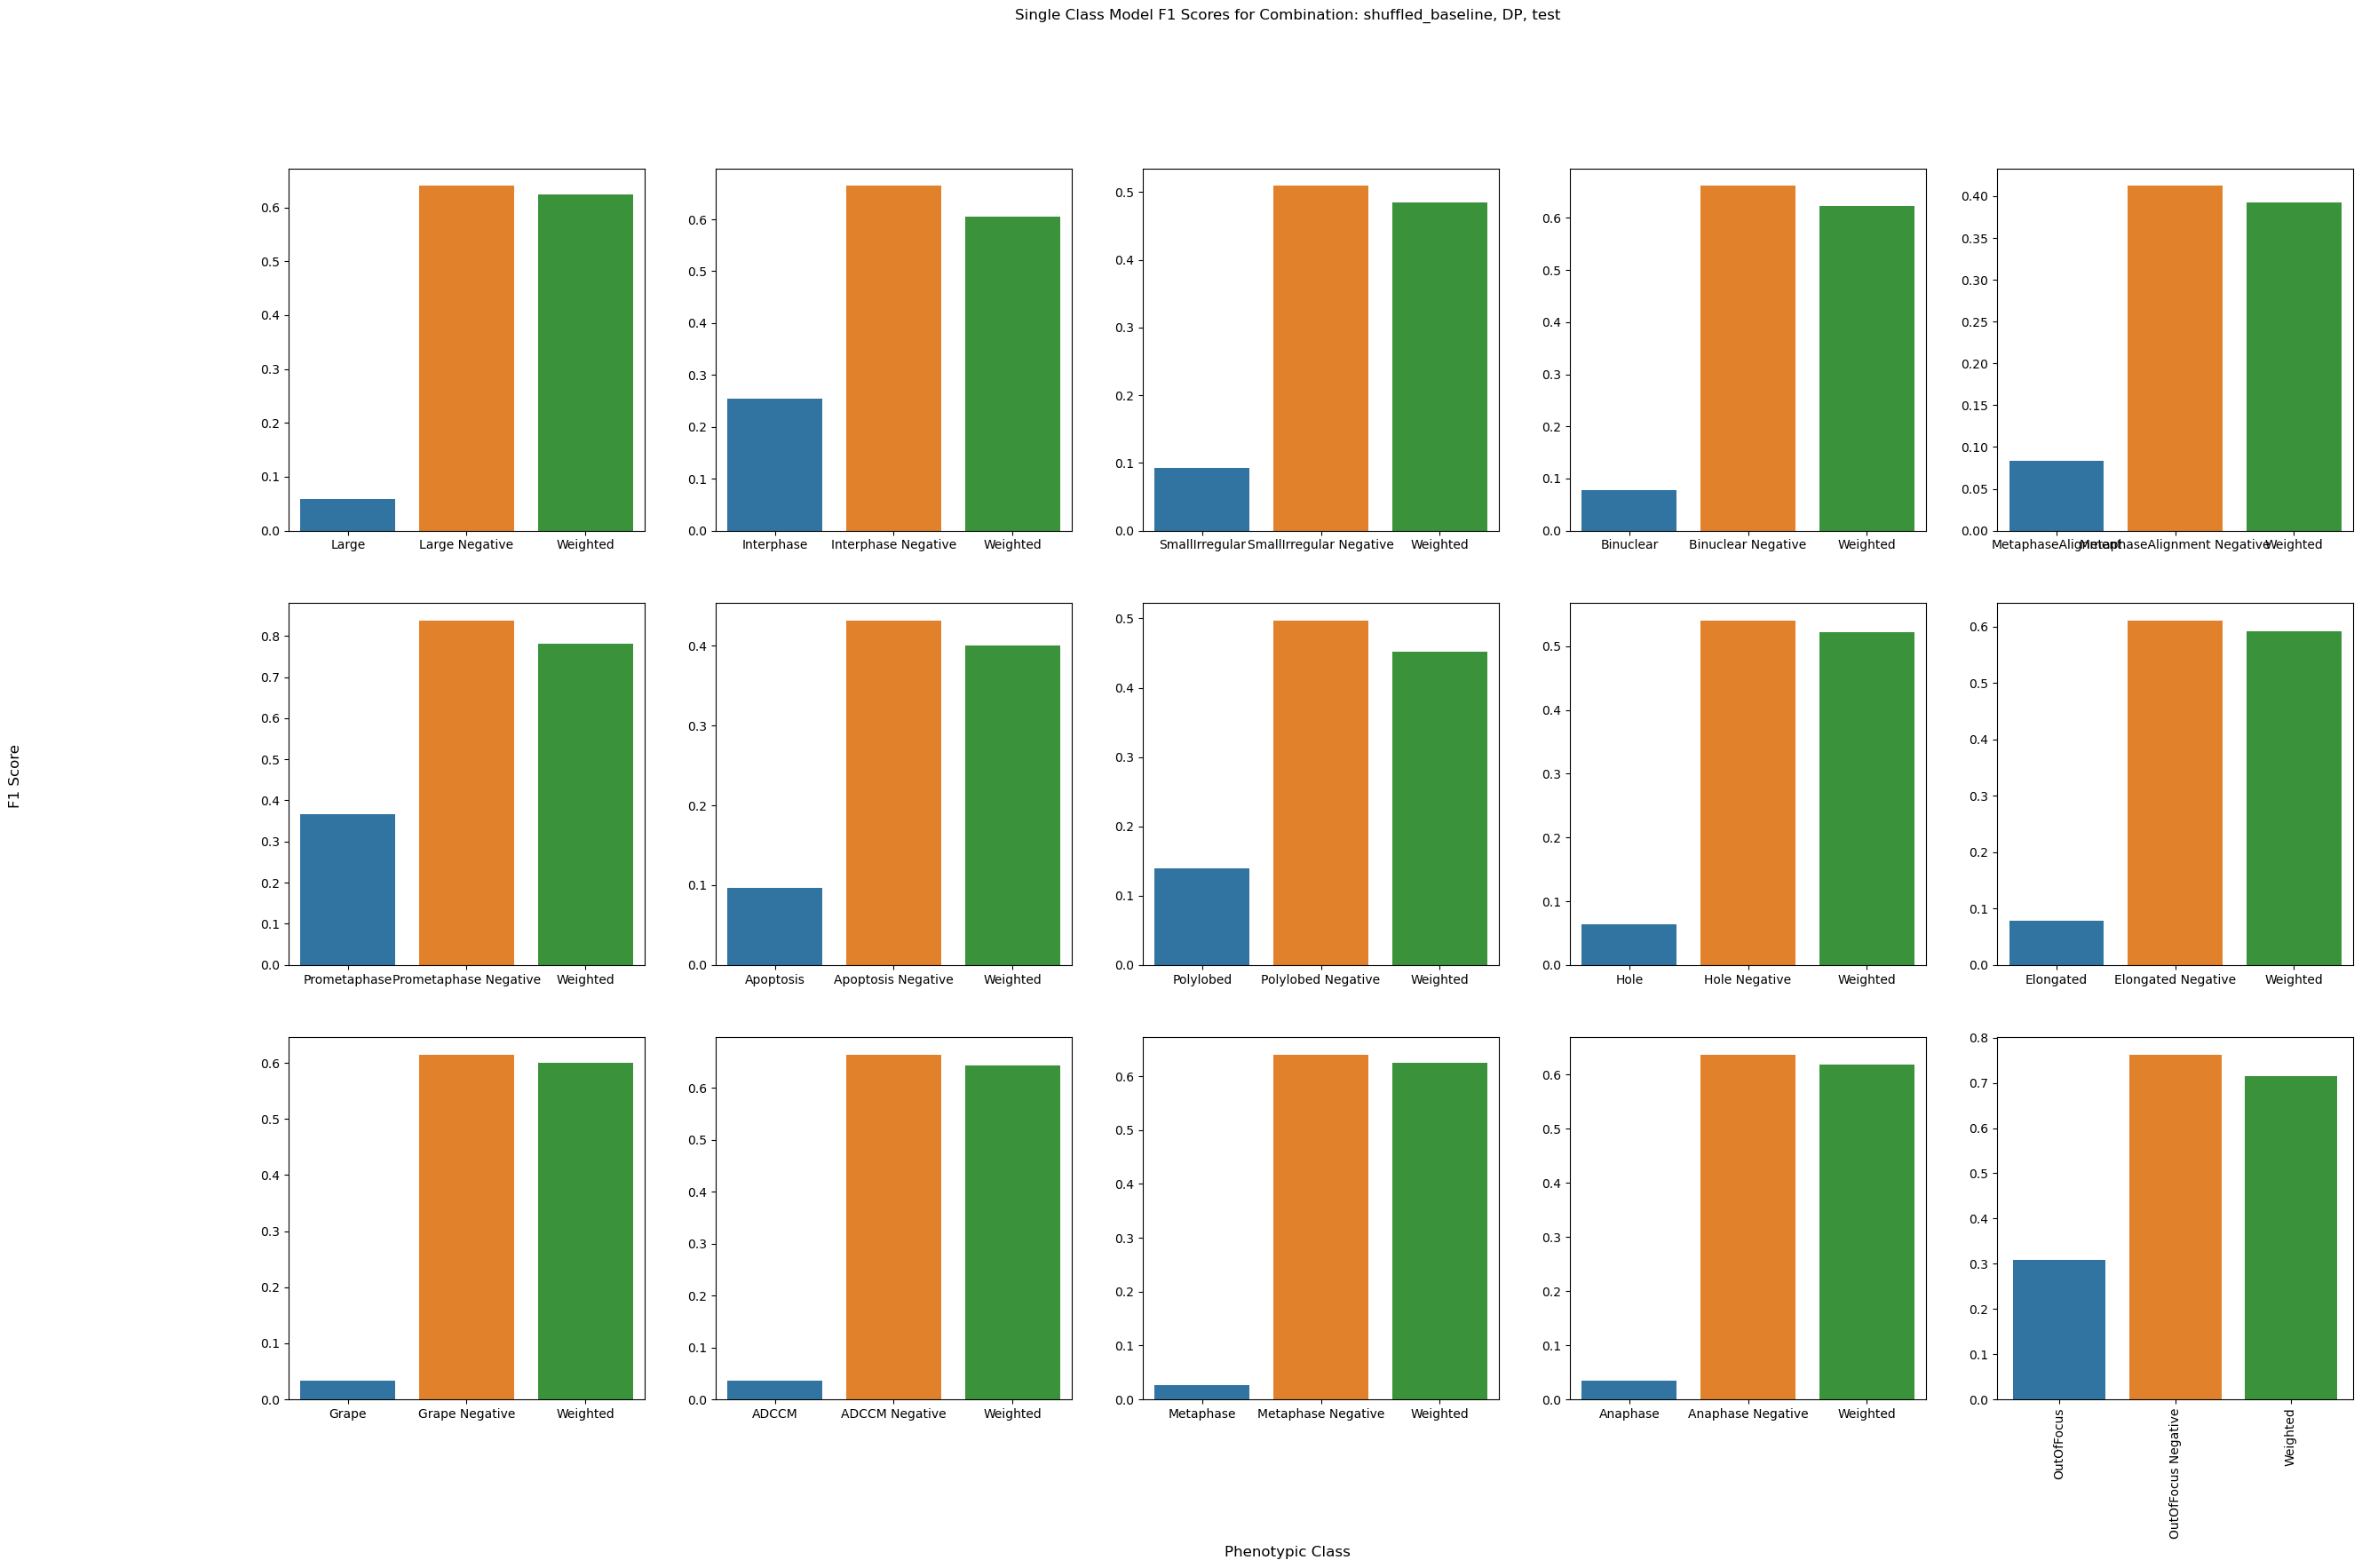

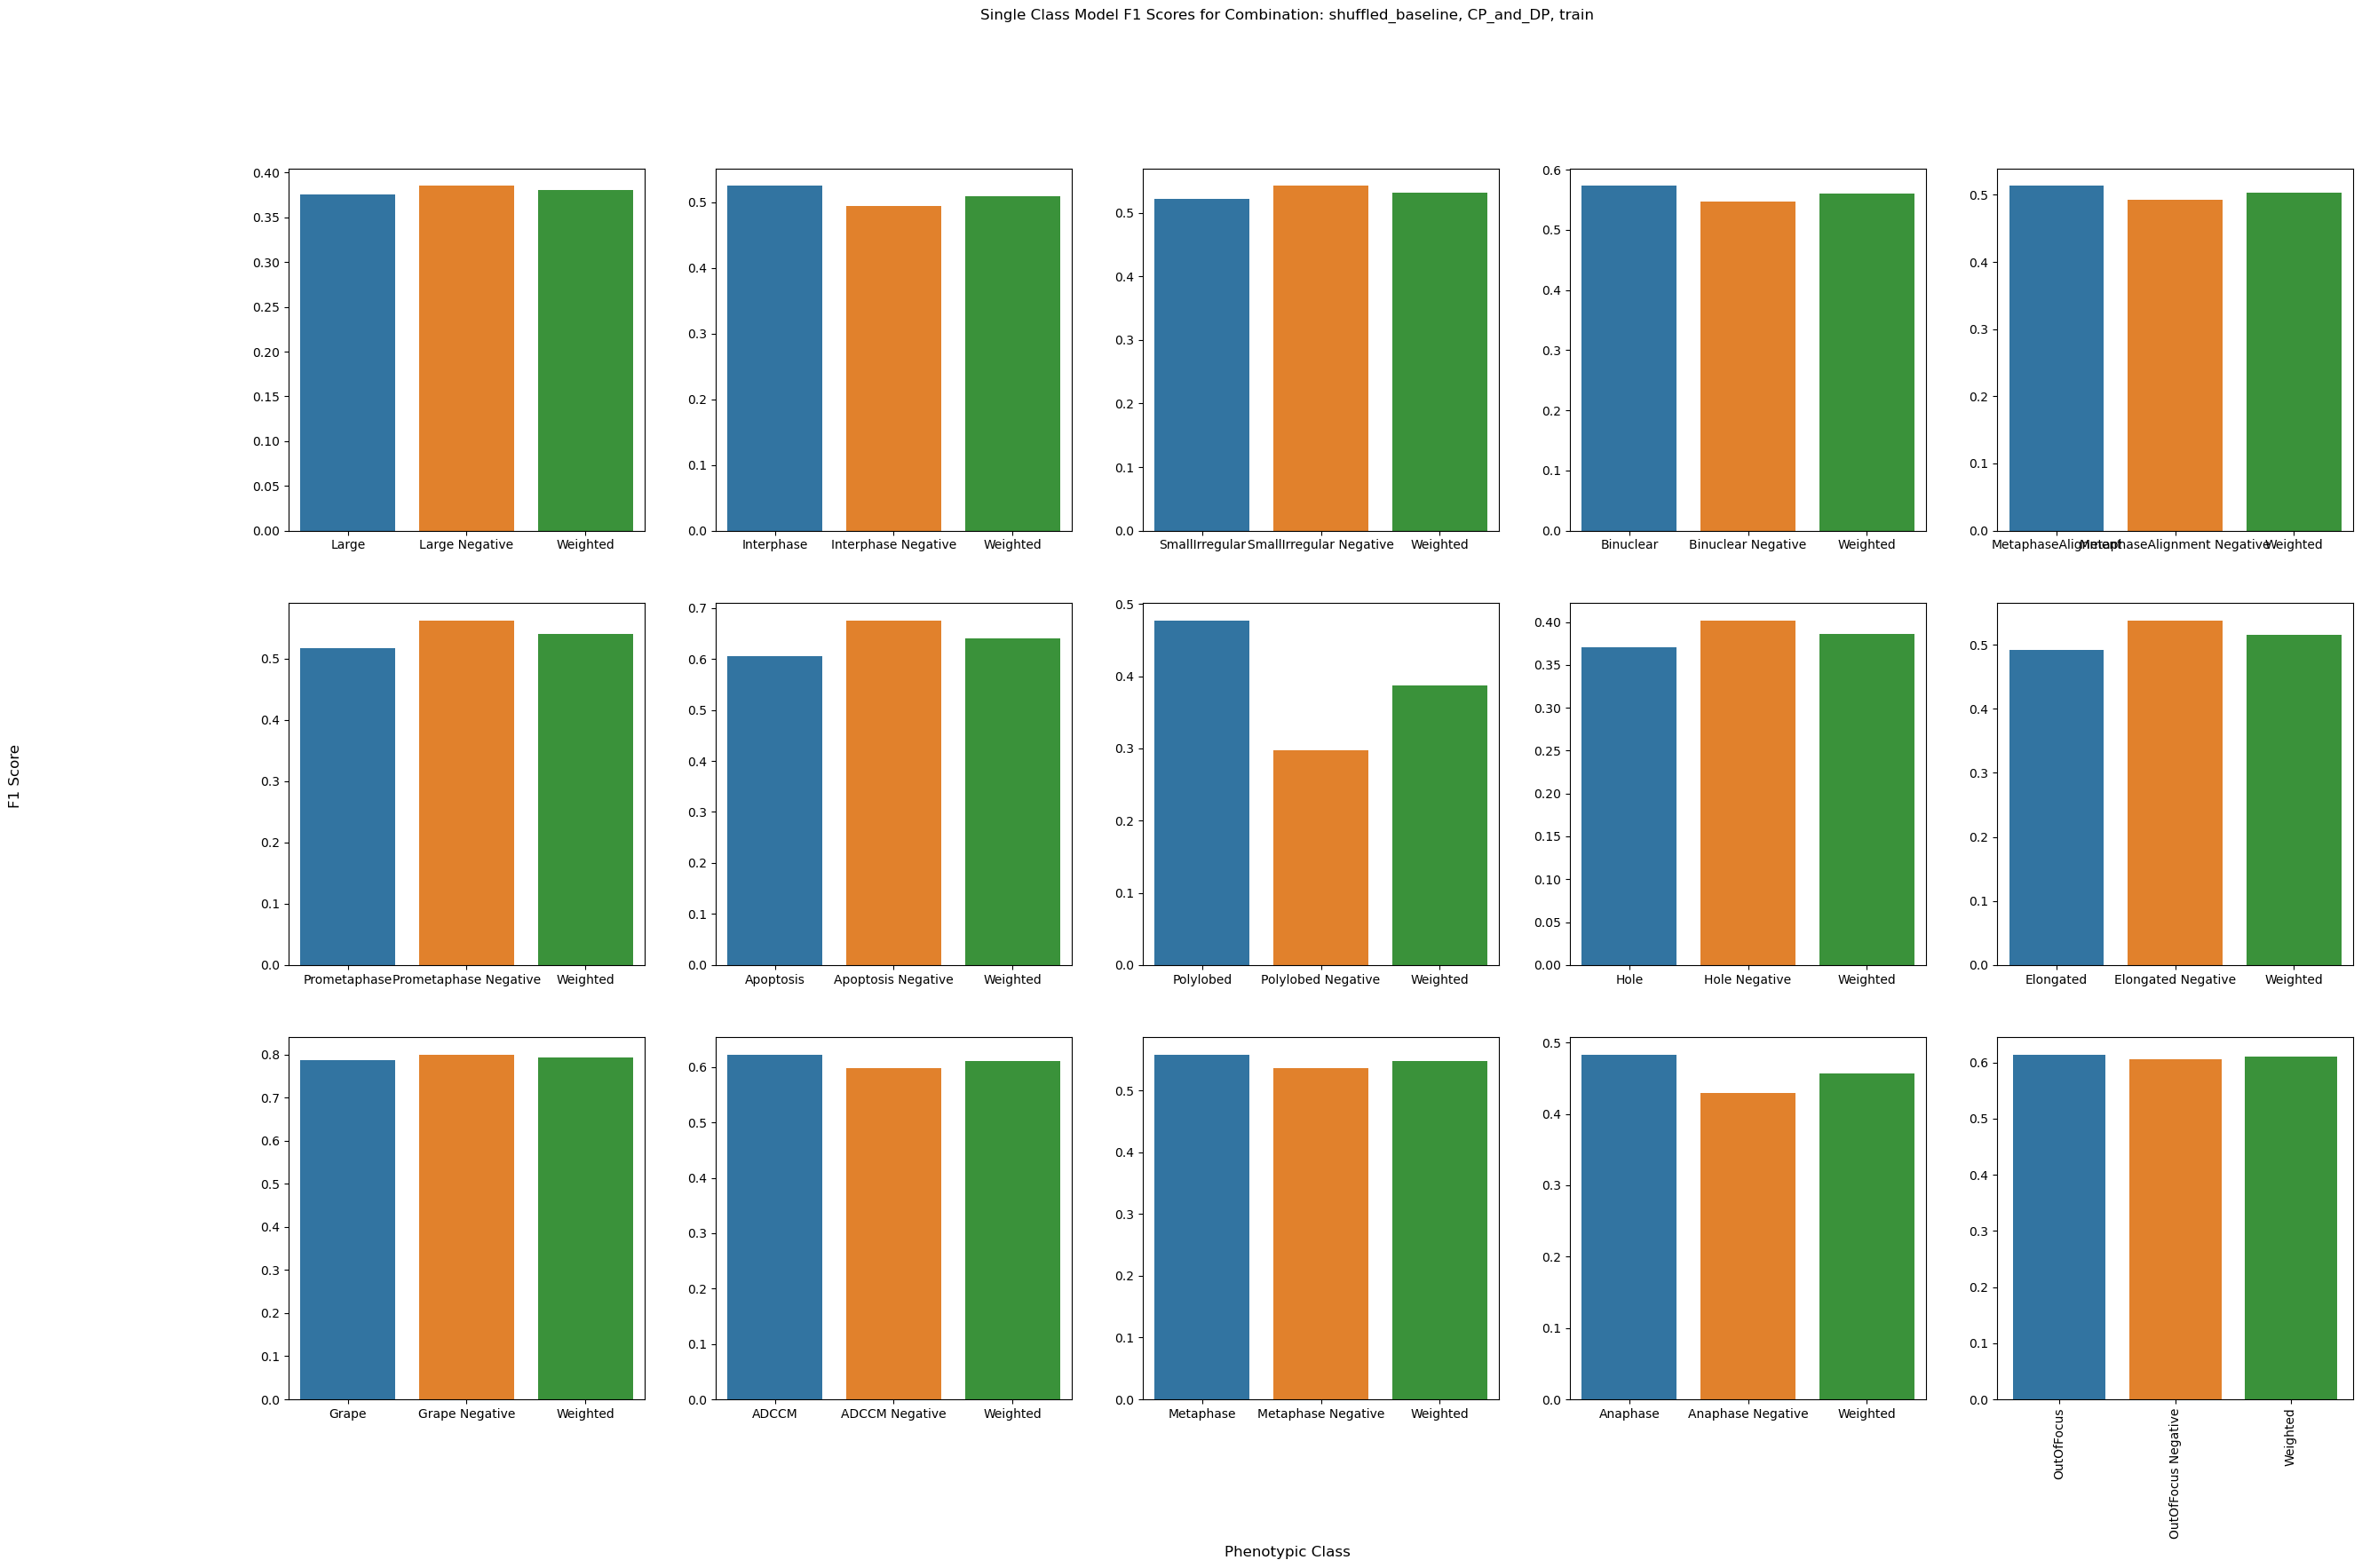

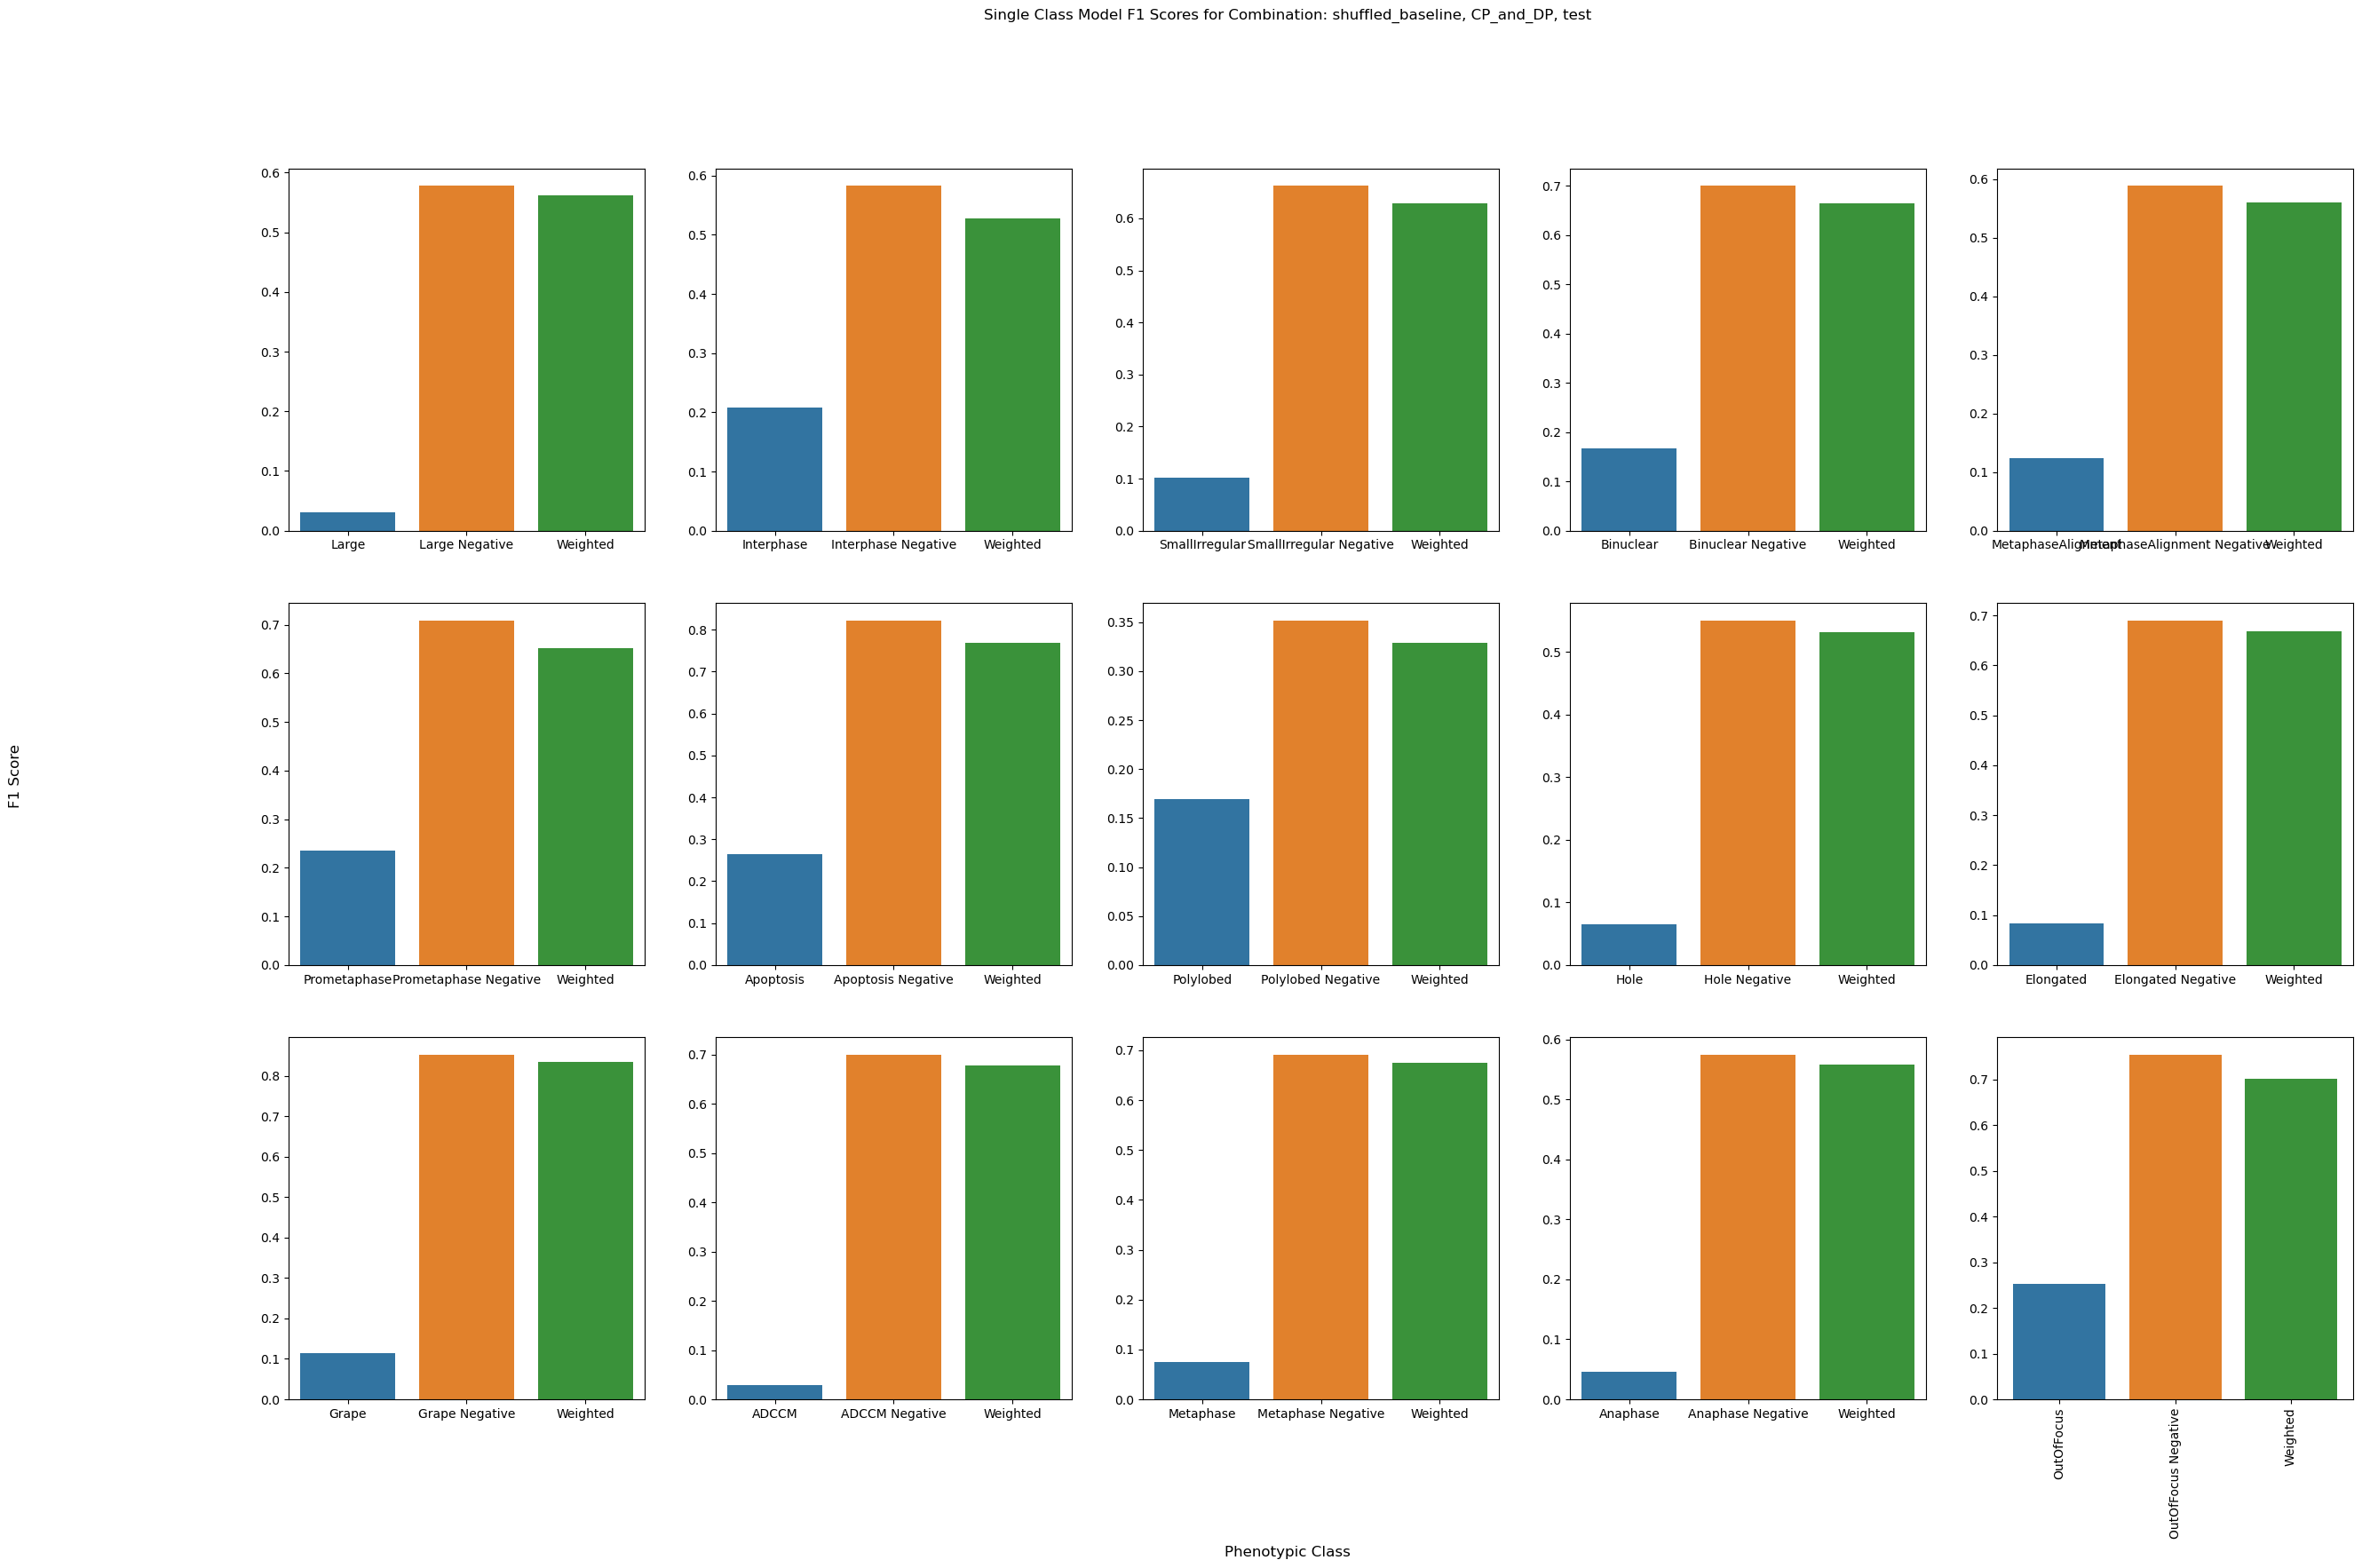

In [5]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/single_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_scores = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
evaluation_types = ["train", "test"]
phenotypic_classes = features_dataframe["Mitocheck_Phenotypic_Class"].unique()

# iterate through each combination of feature_types, evaluation_types, phenotypic_classes
for model_type, feature_type, evaluation_type in itertools.product(
    model_types, feature_types, evaluation_types
):
    # create a figure that has 3x5 subplots for 15 phenotypic classes
    fig, axs = plt.subplots(3, 5)
    fig.set_size_inches(30, 18)
    # variables to keep track of figure subplot coordinates
    ax_x = 0
    ax_y = 0

    for phenotypic_class in phenotypic_classes:
        # load single class model for this combination of model type, feature type, and phenotypic class
        single_class_model_path = pathlib.Path(
            f"{models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)

        # load dataset (train, test, etc)
        single_cell_data = get_dataset(
            features_dataframe, data_split_indexes, evaluation_type
        )
        # rename negative labels and downsample negative labels if we are evaluating on training data
        single_cell_data = get_SCM_model_data(
            single_cell_data, phenotypic_class, evaluation_type
        )

        # find model F1 scores on evaluation dataset
        score, _ = model_F1_score(
            single_class_model, single_cell_data, feature_type, axs[ax_x, ax_y]
        )

        # add score data to compiled dataframe in tidy format
        # transpose data and reset index to make dataframe resemble tidy long format
        score = score.T.reset_index()
        # change columns to their respective names
        score.columns = ["Phenotypic_Class", "F1_Score"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        score["data_split"] = evaluation_type
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        score["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        score["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_scores.append(score)

        # increase row coordinate counter (this marks which subplot to plot on in vertical direction)
        ax_x += 1
        # if row coordinate counter is at maximum (3 rows of subplots)
        if ax_x == 3:
            # set row coordinate counter to 0
            ax_x = 0
            # increase column coordinate counter (this marks which subplot to plot on in horizontal direction)
            ax_y += 1

    # add title and axes labels to figure
    fig.suptitle(
        f"Single Class Model F1 Scores for Combination: {model_type}, {feature_type}, {evaluation_type}"
    )
    fig.supxlabel("Phenotypic Class")
    fig.supylabel("F1 Score")
    plt.plot()

### Save scores from each evaluation (single class models)


In [6]:
# compile list of tidy data into one dataframe
compiled_scores = pd.concat(compiled_scores).reset_index(drop=True)

# specify results directory
f1_scores_dir = pathlib.Path("evaluations/F1_scores/")
f1_scores_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_scores_save_path = pathlib.Path(f"{f1_scores_dir}/compiled_SCM_F1_scores.tsv")

# save data as tsv
compiled_scores.to_csv(compiled_scores_save_path, sep="\t")

# preview tidy data
compiled_scores


,Phenotypic_Class,F1_Score,data_split,shuffled,feature_type
0,Large,0.935252,train,False,CP
1,Large Negative,0.930233,train,False,CP
2,Weighted,0.932742,train,False,CP
3,Prometaphase,0.938843,train,False,CP
4,Prometaphase Negative,0.934744,train,False,CP
...,...,...,...,...,...
535,Elongated Negative,0.690513,test,True,CP_and_DP
536,Weighted,0.667906,test,True,CP_and_DP
537,OutOfFocus,0.253521,test,True,CP_and_DP
538,OutOfFocus Negative,0.754250,test,True,CP_and_DP
